# Начало

### Визуализация

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_diffs(s_list, instant_introduction_density, volume_total, density):
    # проверки
    assert len(s_list) == len(instant_introduction_density), (
        f"Размерности не совпадают: len(s_list)={len(s_list)}, "
        f"len(density)={len(instant_introduction_density)}. "
        "Должно выполняться len(s_list) == len(density)."
    )

    # Δs между точками (в метрах)
    ds = np.diff(s_list)  # длина N-1

    # усредняем плотность на интервалах (среднее между соседними точками)
    dens_interval = 0.5 * (instant_introduction_density[1:] + instant_introduction_density[:-1])

    # фактический накопленный объём по дистанции
    fact_cumulative = np.concatenate([[0], np.cumsum(dens_interval * ds)])

    # ожидаемая линейная кривая (идеальное равномерное внесение)
    expected_cumulative = np.linspace(0, volume_total, len(s_list))

    # === Визуализация ===
    plt.figure(figsize=(10, 5))
    plt.plot(s_list, fact_cumulative, label="Фактическое внесение", linewidth=2)
    plt.plot(s_list, expected_cumulative, label="Ожидаемое внесение", linestyle="--", linewidth=2)
    plt.xlabel("Дистанция, м")
    plt.ylabel("Накопленный объём, л")
    plt.title("Накопленное распределение внесения по пути")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Отклонение от идеала
    error = fact_cumulative - expected_cumulative
    plt.figure(figsize=(10, 4))
    plt.plot(s_list, error, label="Отклонение от идеала")
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Дистанция, м")
    plt.ylabel("Ошибка, л")
    plt.title("Локальное отклонение по накопленному объёму")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Мгновенная плотность внесения
    plt.figure(figsize=(10, 4))
    plt.plot(s_list, instant_introduction_density, label="Фактическая плотность")
    plt.axhline(density, color="red", linestyle="--", label="Ожидаемая плотность")
    plt.xlabel("Дистанция, м")
    plt.ylabel("Плотность внесения, л/м")
    plt.title("Мгновенная плотность внесения")
    plt.legend()
    plt.grid(True)
    plt.show()


In [39]:
import numpy as np

from dto import Point, GeoPoint
from SpeedPredictor import MotionConstraints, PureLateralLimitTurnPolicy, SpeedPredictor
from PumpController import BoundaryAction, PumpConstraints, PumpController
from utils import polyline_lengths, point_on_path, simulate_time_param
from plots import plot_polygon

## Загрузка лог файла

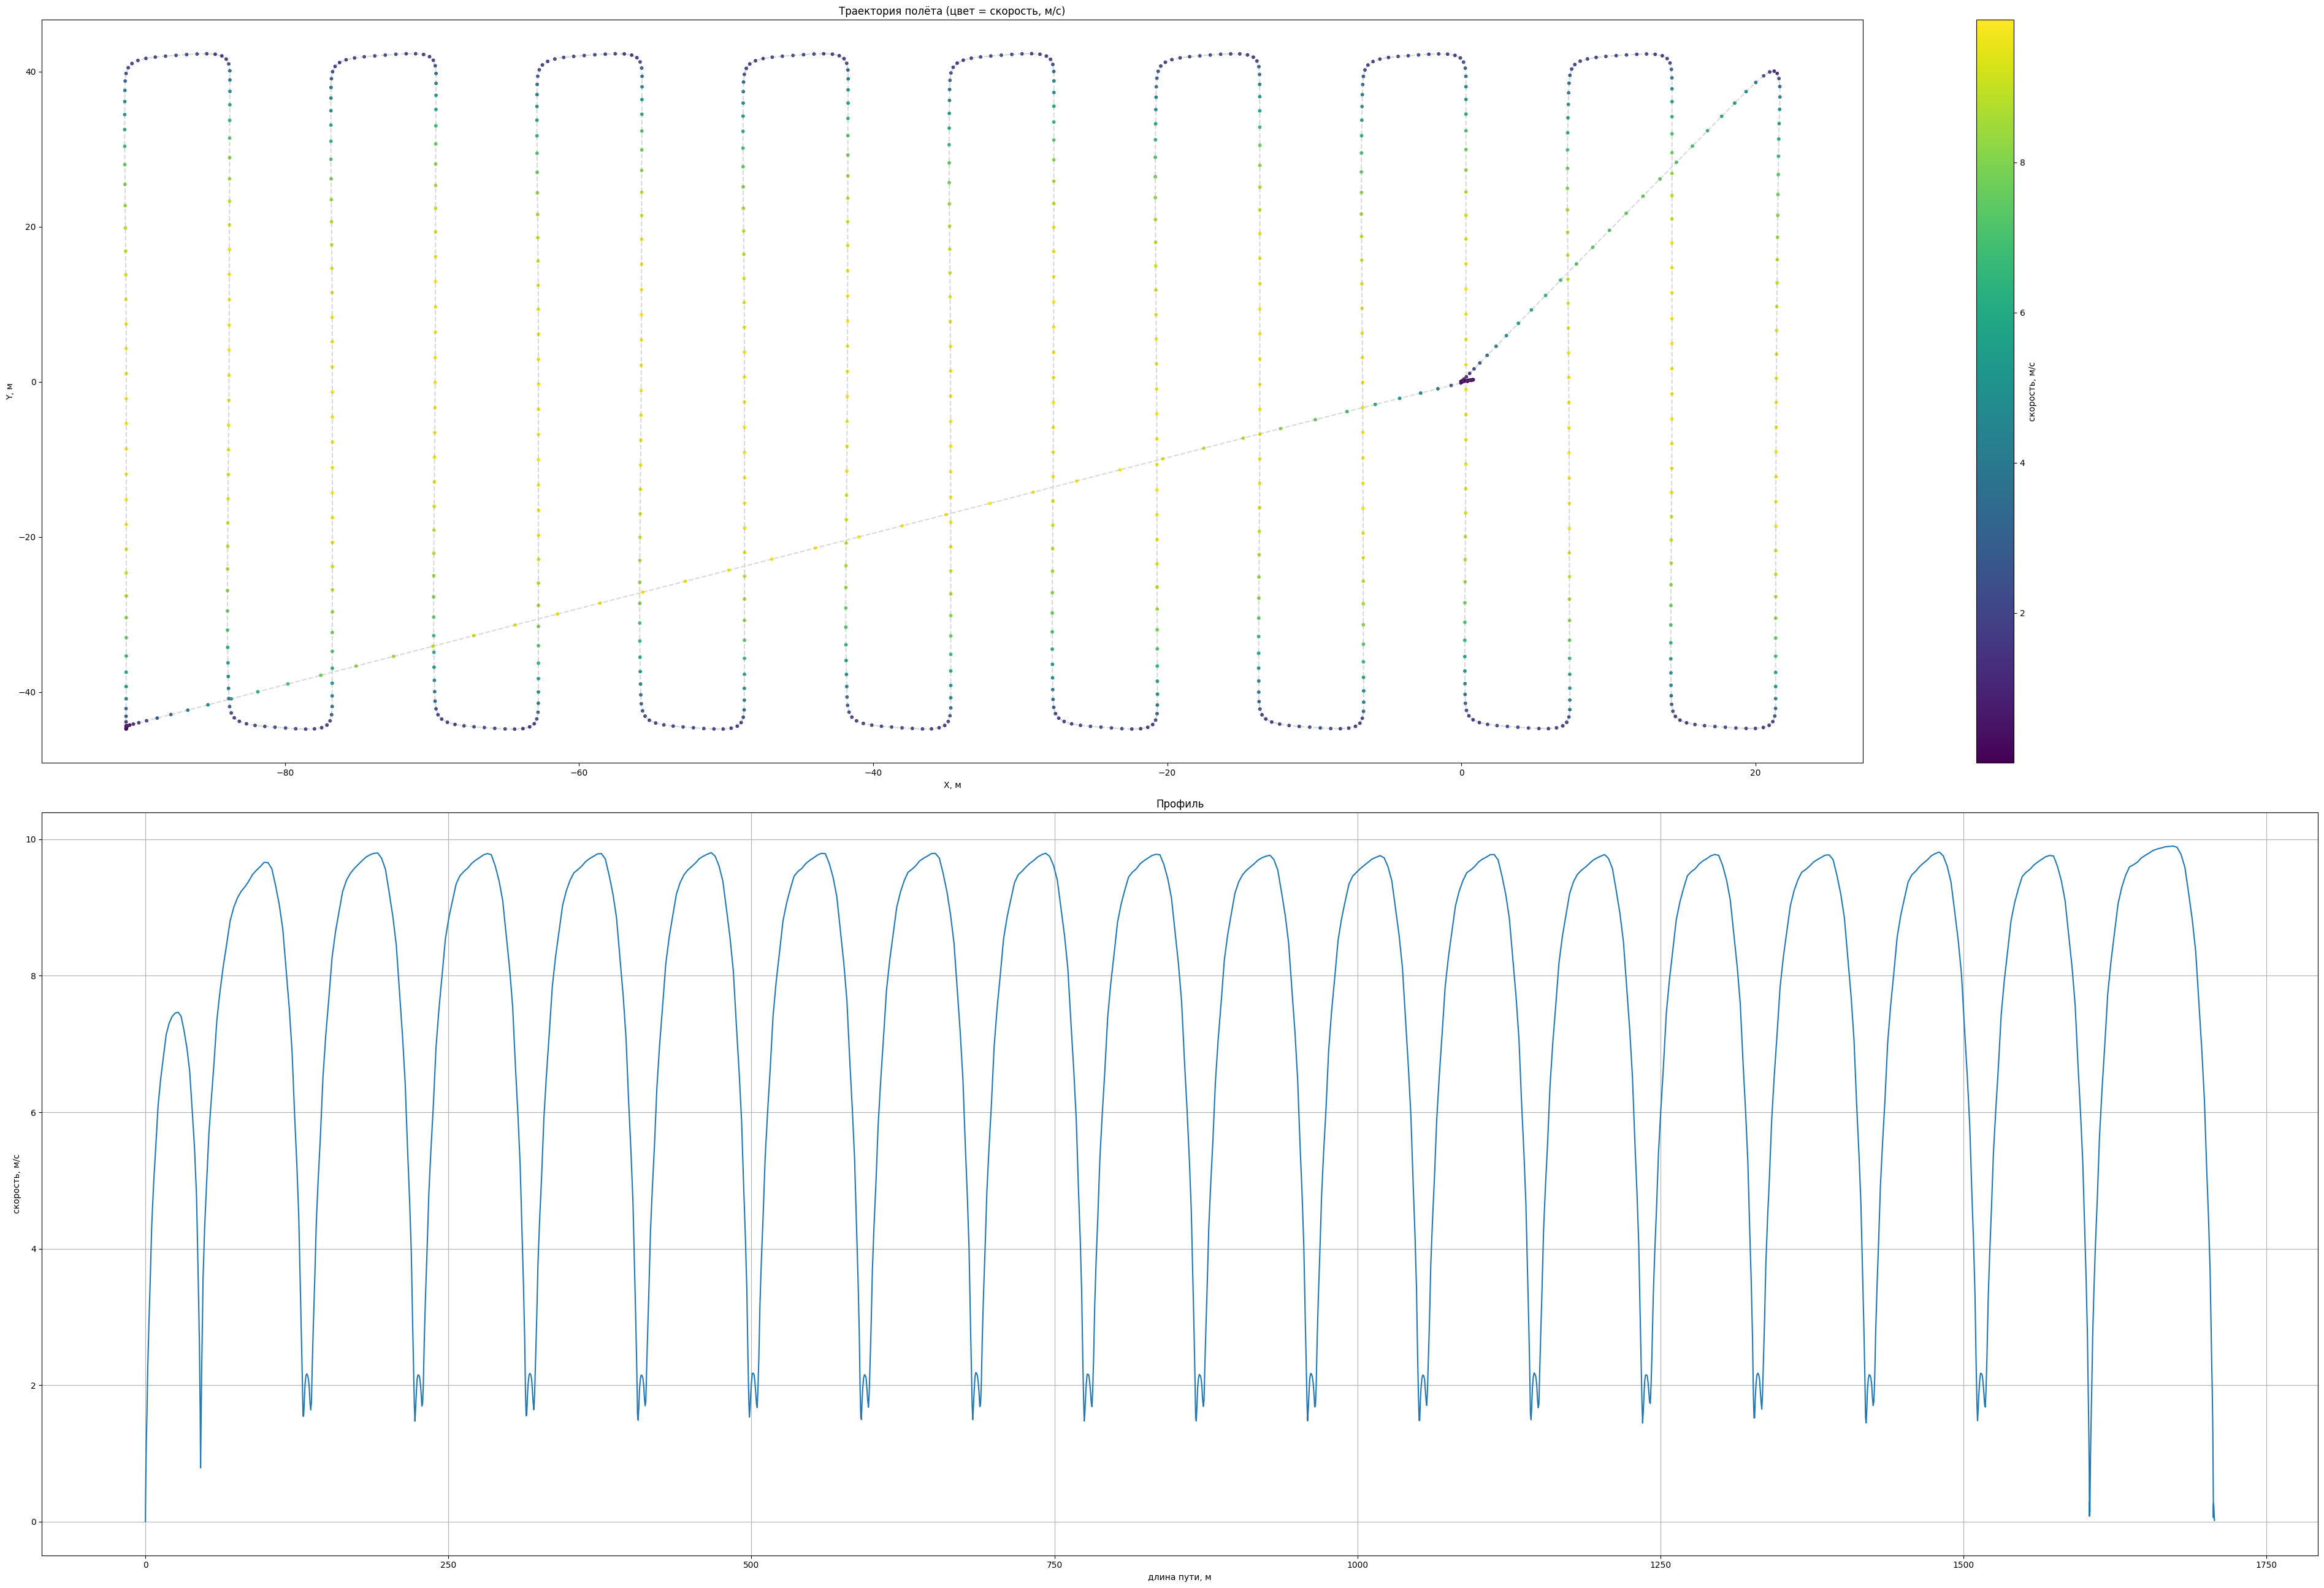

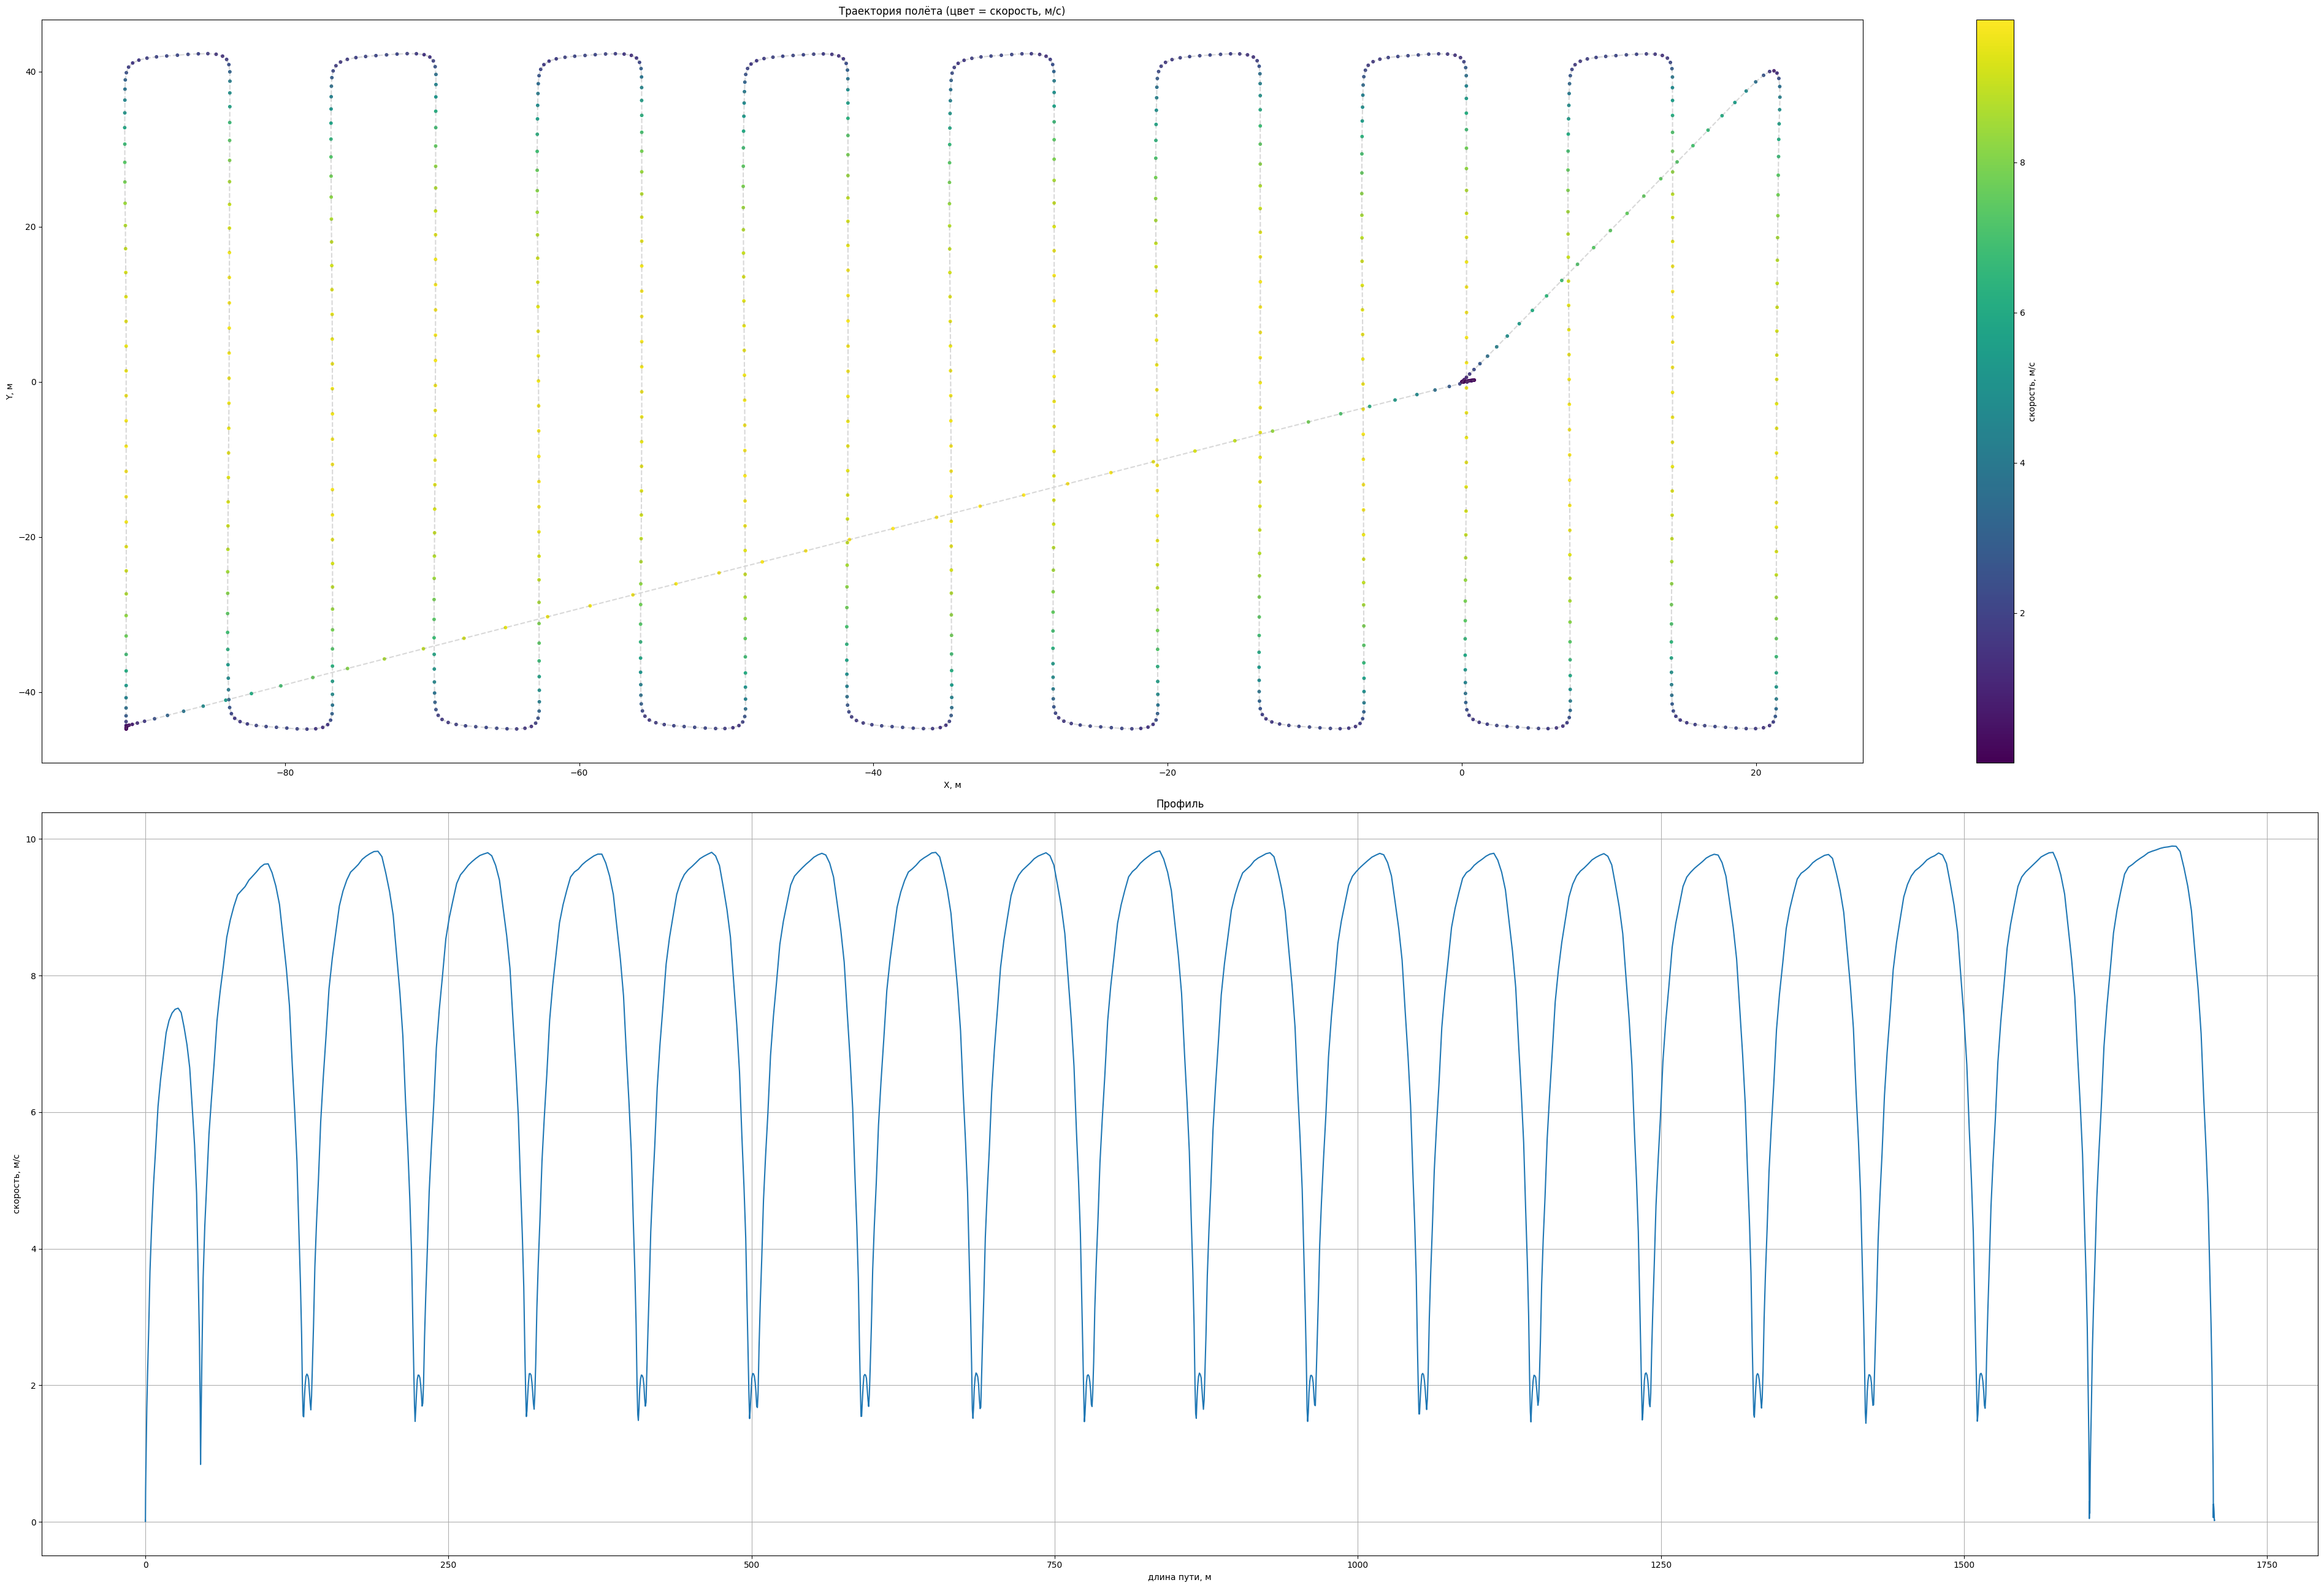

[Warning] Корректная обработка полётов в количестве более 1 ещё не реализована


In [40]:
from parse_log import Plan, Logs
from pathlib import Path

path_to_file = Path(
    r"C:\Users\nodax\Downloads\Telegram Desktop\spraying_20250908_080420_485_24a89b48_9ecb_4956_bdb3_4d01f9de0f4a.json")

plan = Plan.get_plan_from_log_file(path_to_file)

in_logs = Logs(path_to_file)

## Визуализация плана мисии

In [41]:

from GeoTransformer import GeoTransformer

geo_transformer = GeoTransformer()


def to_xy(p: GeoPoint) -> Point:
    return geo_transformer.geo_to_xy(plan.center_geo, p)


def to_geo(p: Point) -> GeoPoint:
    return geo_transformer.xy_to_geo(plan.center_geo, p)


def to_xy_points(gp: list[GeoPoint]) -> list[Point]:
    return [to_xy(p) for p in gp]

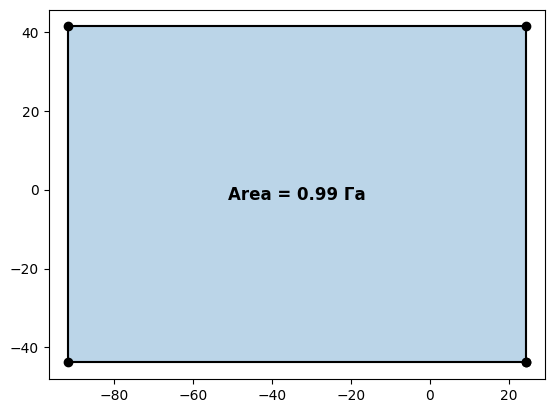

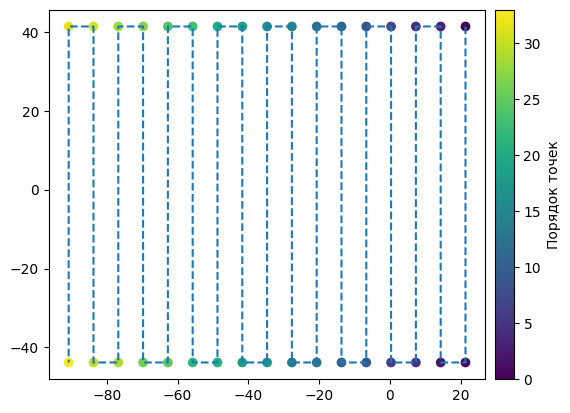

In [42]:
from plots import scatter_with_color

plot_polygon(plan.polygon)
scatter_with_color(plan.waypoints_xy, list(range(len(plan.waypoints_xy))), 'Порядок точек')

# Ограничения

In [64]:
motion = MotionConstraints(
    v_max=10.0,
    a_max=1.0,
    d_max=1.0,
    yaw_rate=10,
    turn_radius=2,
    a_lat_max=2.0,
    angle_eps_deg=1.0,
    start_speed=0.0,
    end_speed=0.0
)

predictor = SpeedPredictor(motion, PureLateralLimitTurnPolicy())

norma = 1  # Норма внесения Литры/Га
pump_min_speed = 1  # л/мин
pump_max_speed = 13  # л/мин
tank_volume = 4  # л

constraints = PumpConstraints(
    q_min=pump_min_speed / 60,  # л/с
    q_max=pump_max_speed / 60,  # л/с
    tank_volume=tank_volume,  # л
    low_mode=BoundaryAction.CLAMP,
    high_mode=BoundaryAction.CLAMP,
)

pump = PumpController(constraints)


# Предсказанный на основе плана

## Предсказанный профиль скорости дрона

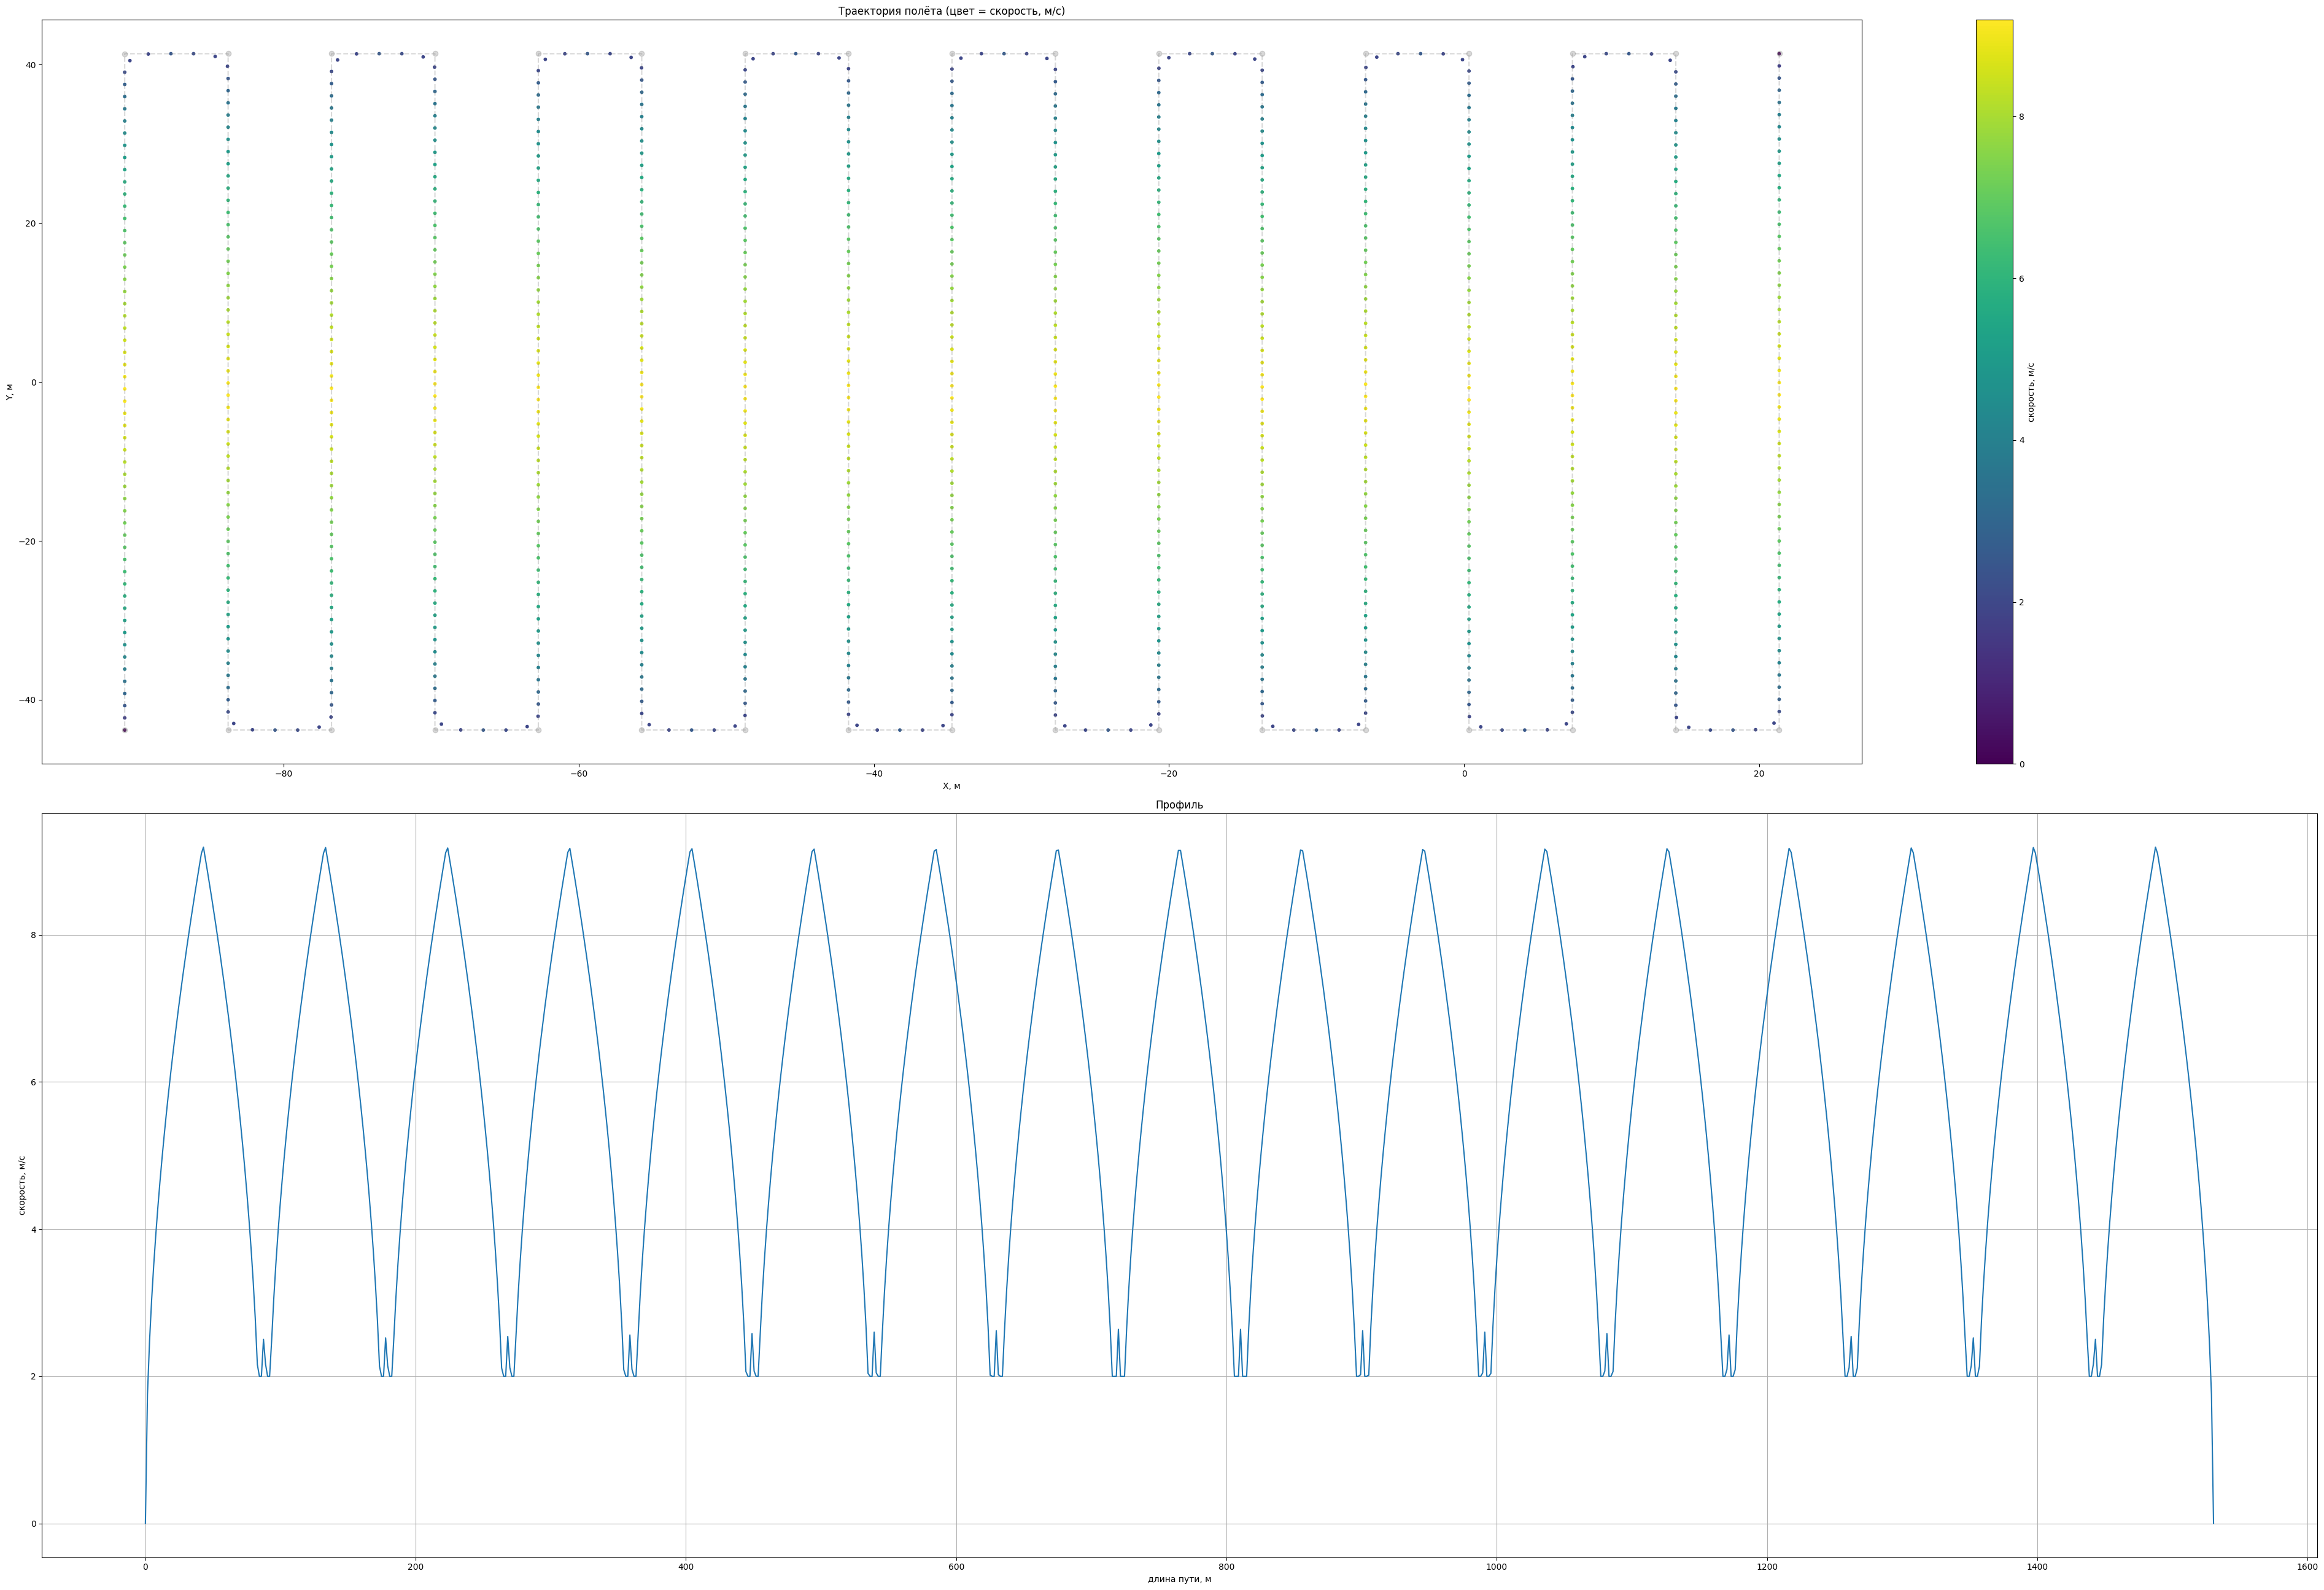

In [65]:
from plots import scatter_with_color_and_profile

profile_by_plan = predictor.build_profile(plan.waypoints_xy)

s_list = np.linspace(0, profile_by_plan.total_distance, 1000)
pts_list = [profile_by_plan.point_at_distance(s) for s in s_list]
speed_list = [profile_by_plan.speed_at_distance(s) for s in s_list]

scatter_with_color_and_profile(pts_list, speed_list, waypoints=plan.waypoints_xy)

## Предсказанный режим работы насоса

In [66]:
from plots import plot_speeds_profile, plot_density_profile

t_list, s_list, speed_list = profile_by_plan.simulate_time_param(dt=0.01)

V_total = plan.calculate_total_volume(norma)  # л — нужно вылить на всём маршруте

pump_series_by_plan = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list,
    length=profile_by_plan.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile_by_plan.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(pump_series_by_plan) :.2f} л")
empty_s_list = [profile_by_plan.distance_at_time(t) for t, v in pump_series_by_plan.empty_events]

if pump_series_by_plan.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(pump_series_by_plan.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")

Длина маршрута L = 1532.74 м
Плановый объём V_total = 0.99 л
Фактически выльется (с учётом ограничений насоса): 5.35 л
Моменты опустошения бака:
	t = 240.01 с, s = 1157.40 м


In [67]:
pump.total_dispensed(pump_series_by_plan) / plan.polygon.area * 10_000

5.403233797289386

## Профили скоростей (дрон, насос)

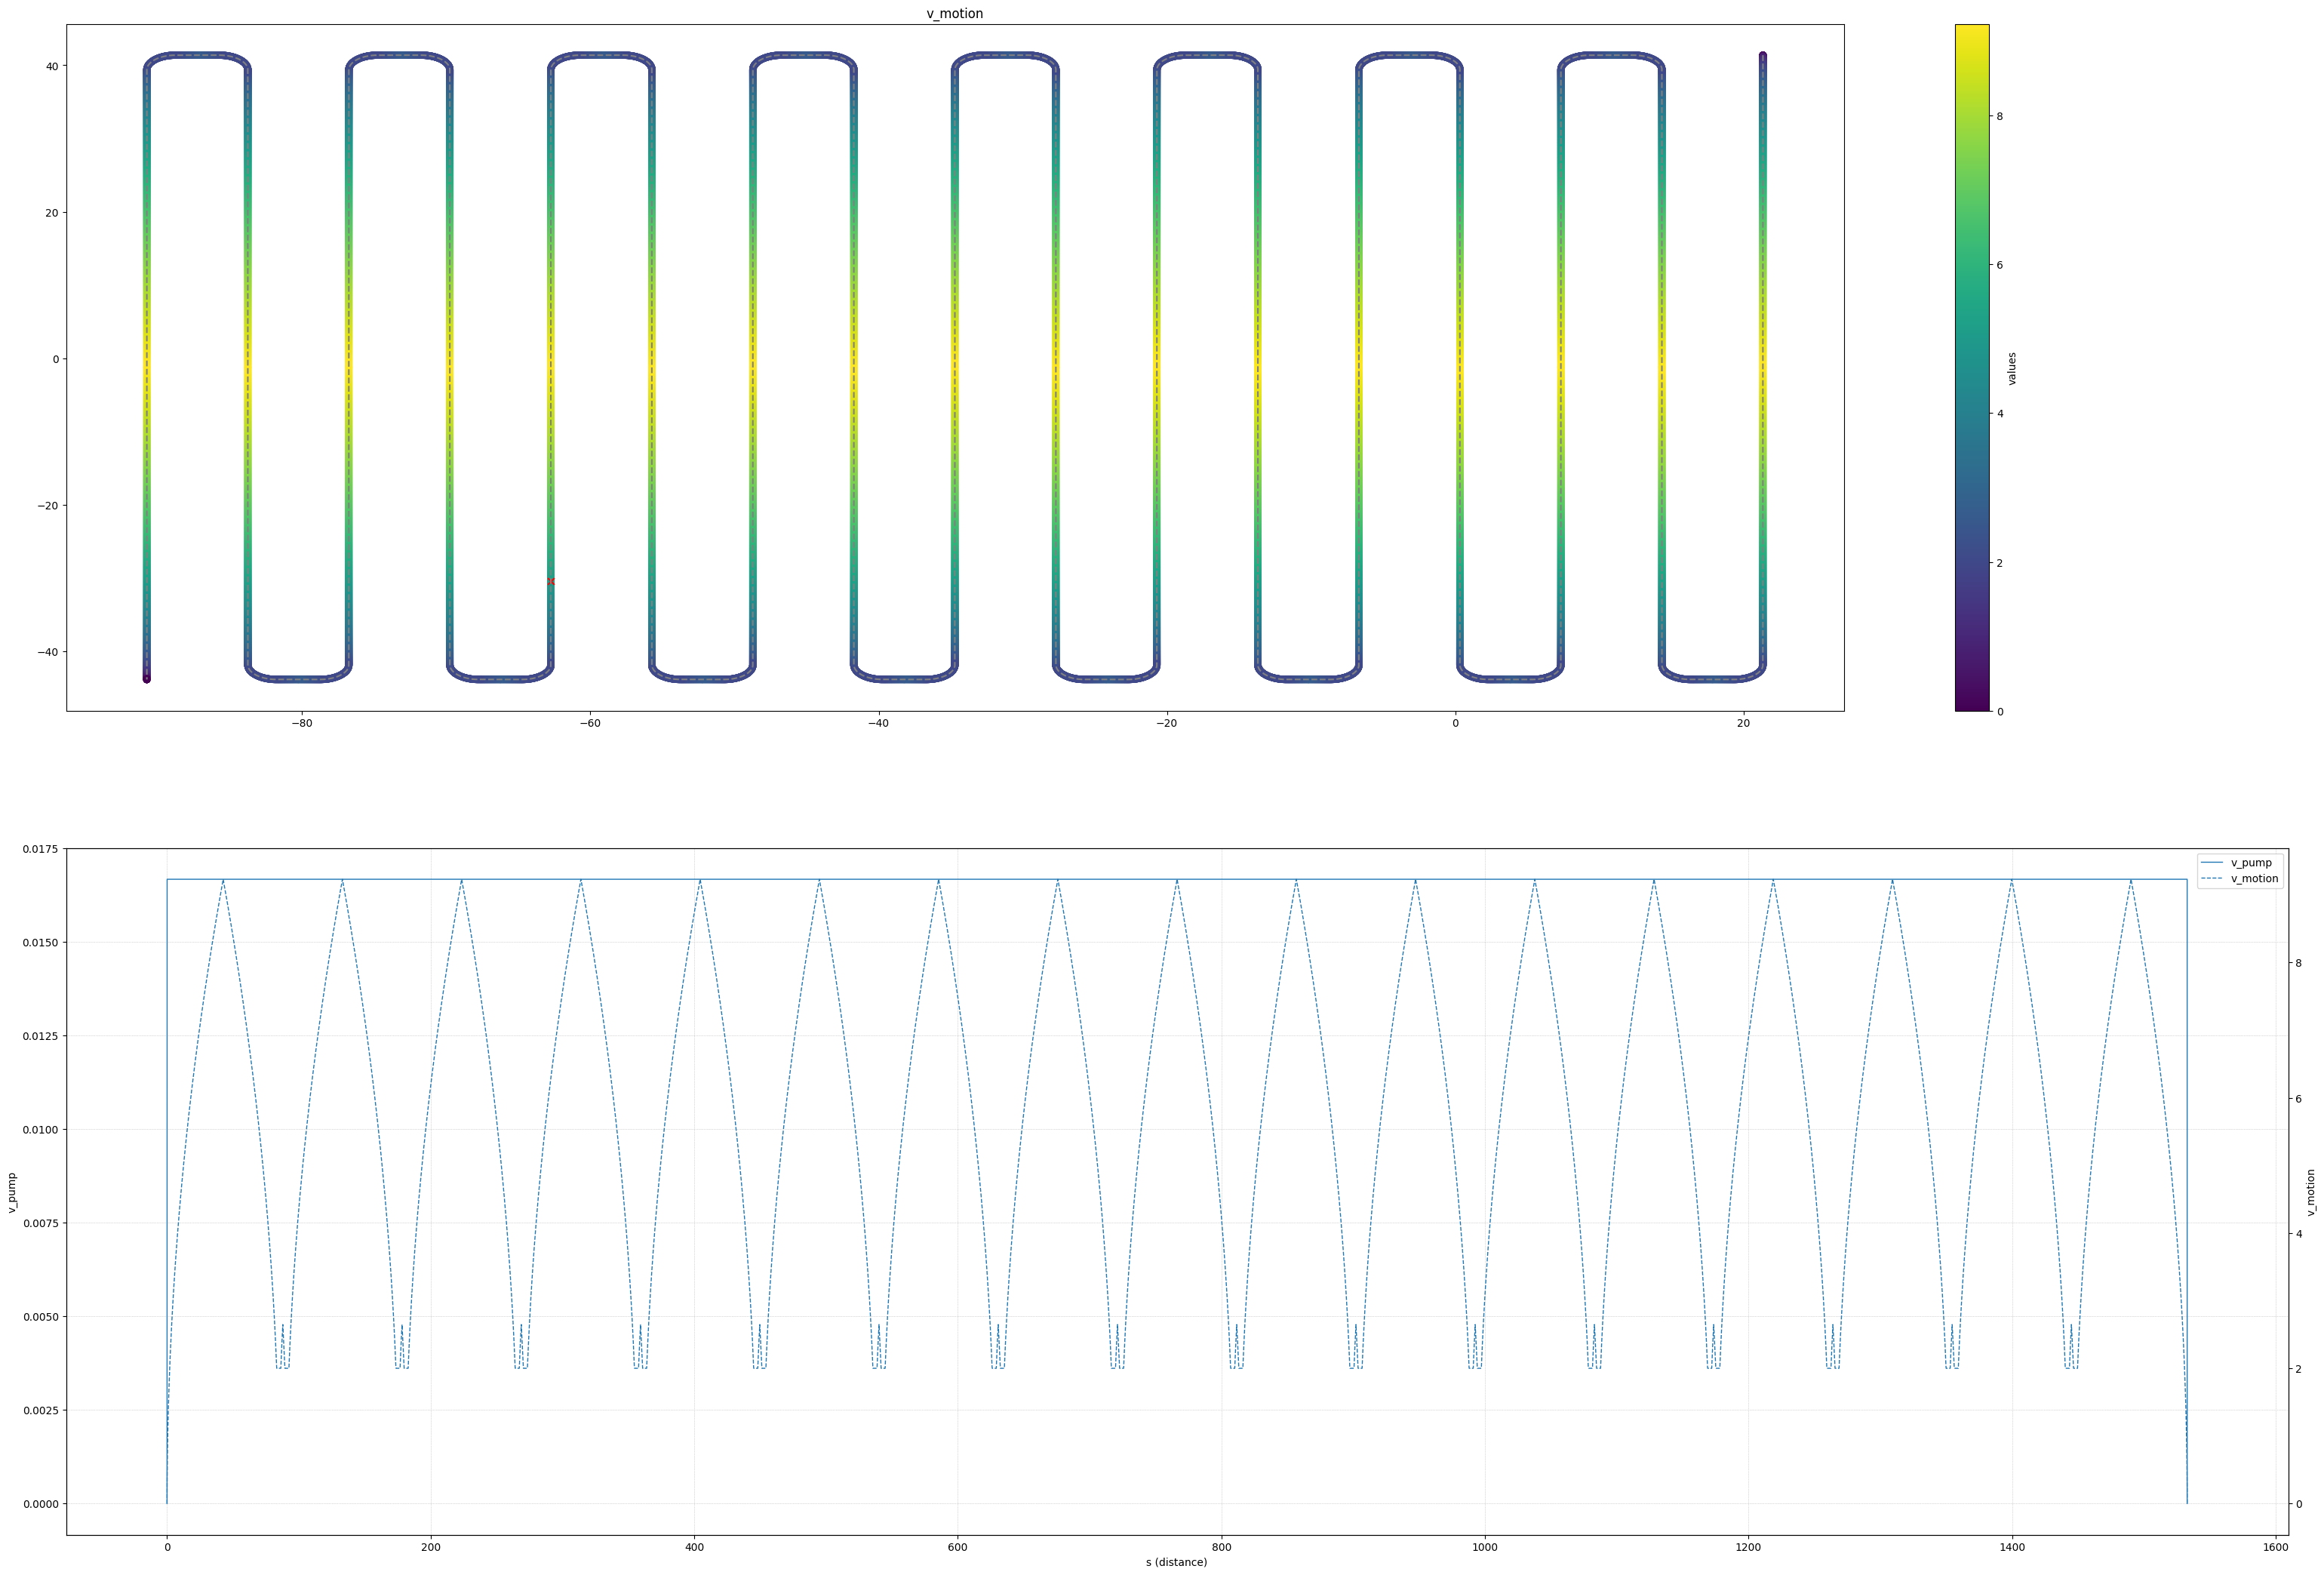

In [68]:
list_pts = [profile_by_plan.point_at_distance(s) for s in s_list]


plot_speeds_profile(list_pts,
                    s_list,
                    pump_series_by_plan.q,
                    speed_list,
                    empty_s_list)

## Плотность внесения

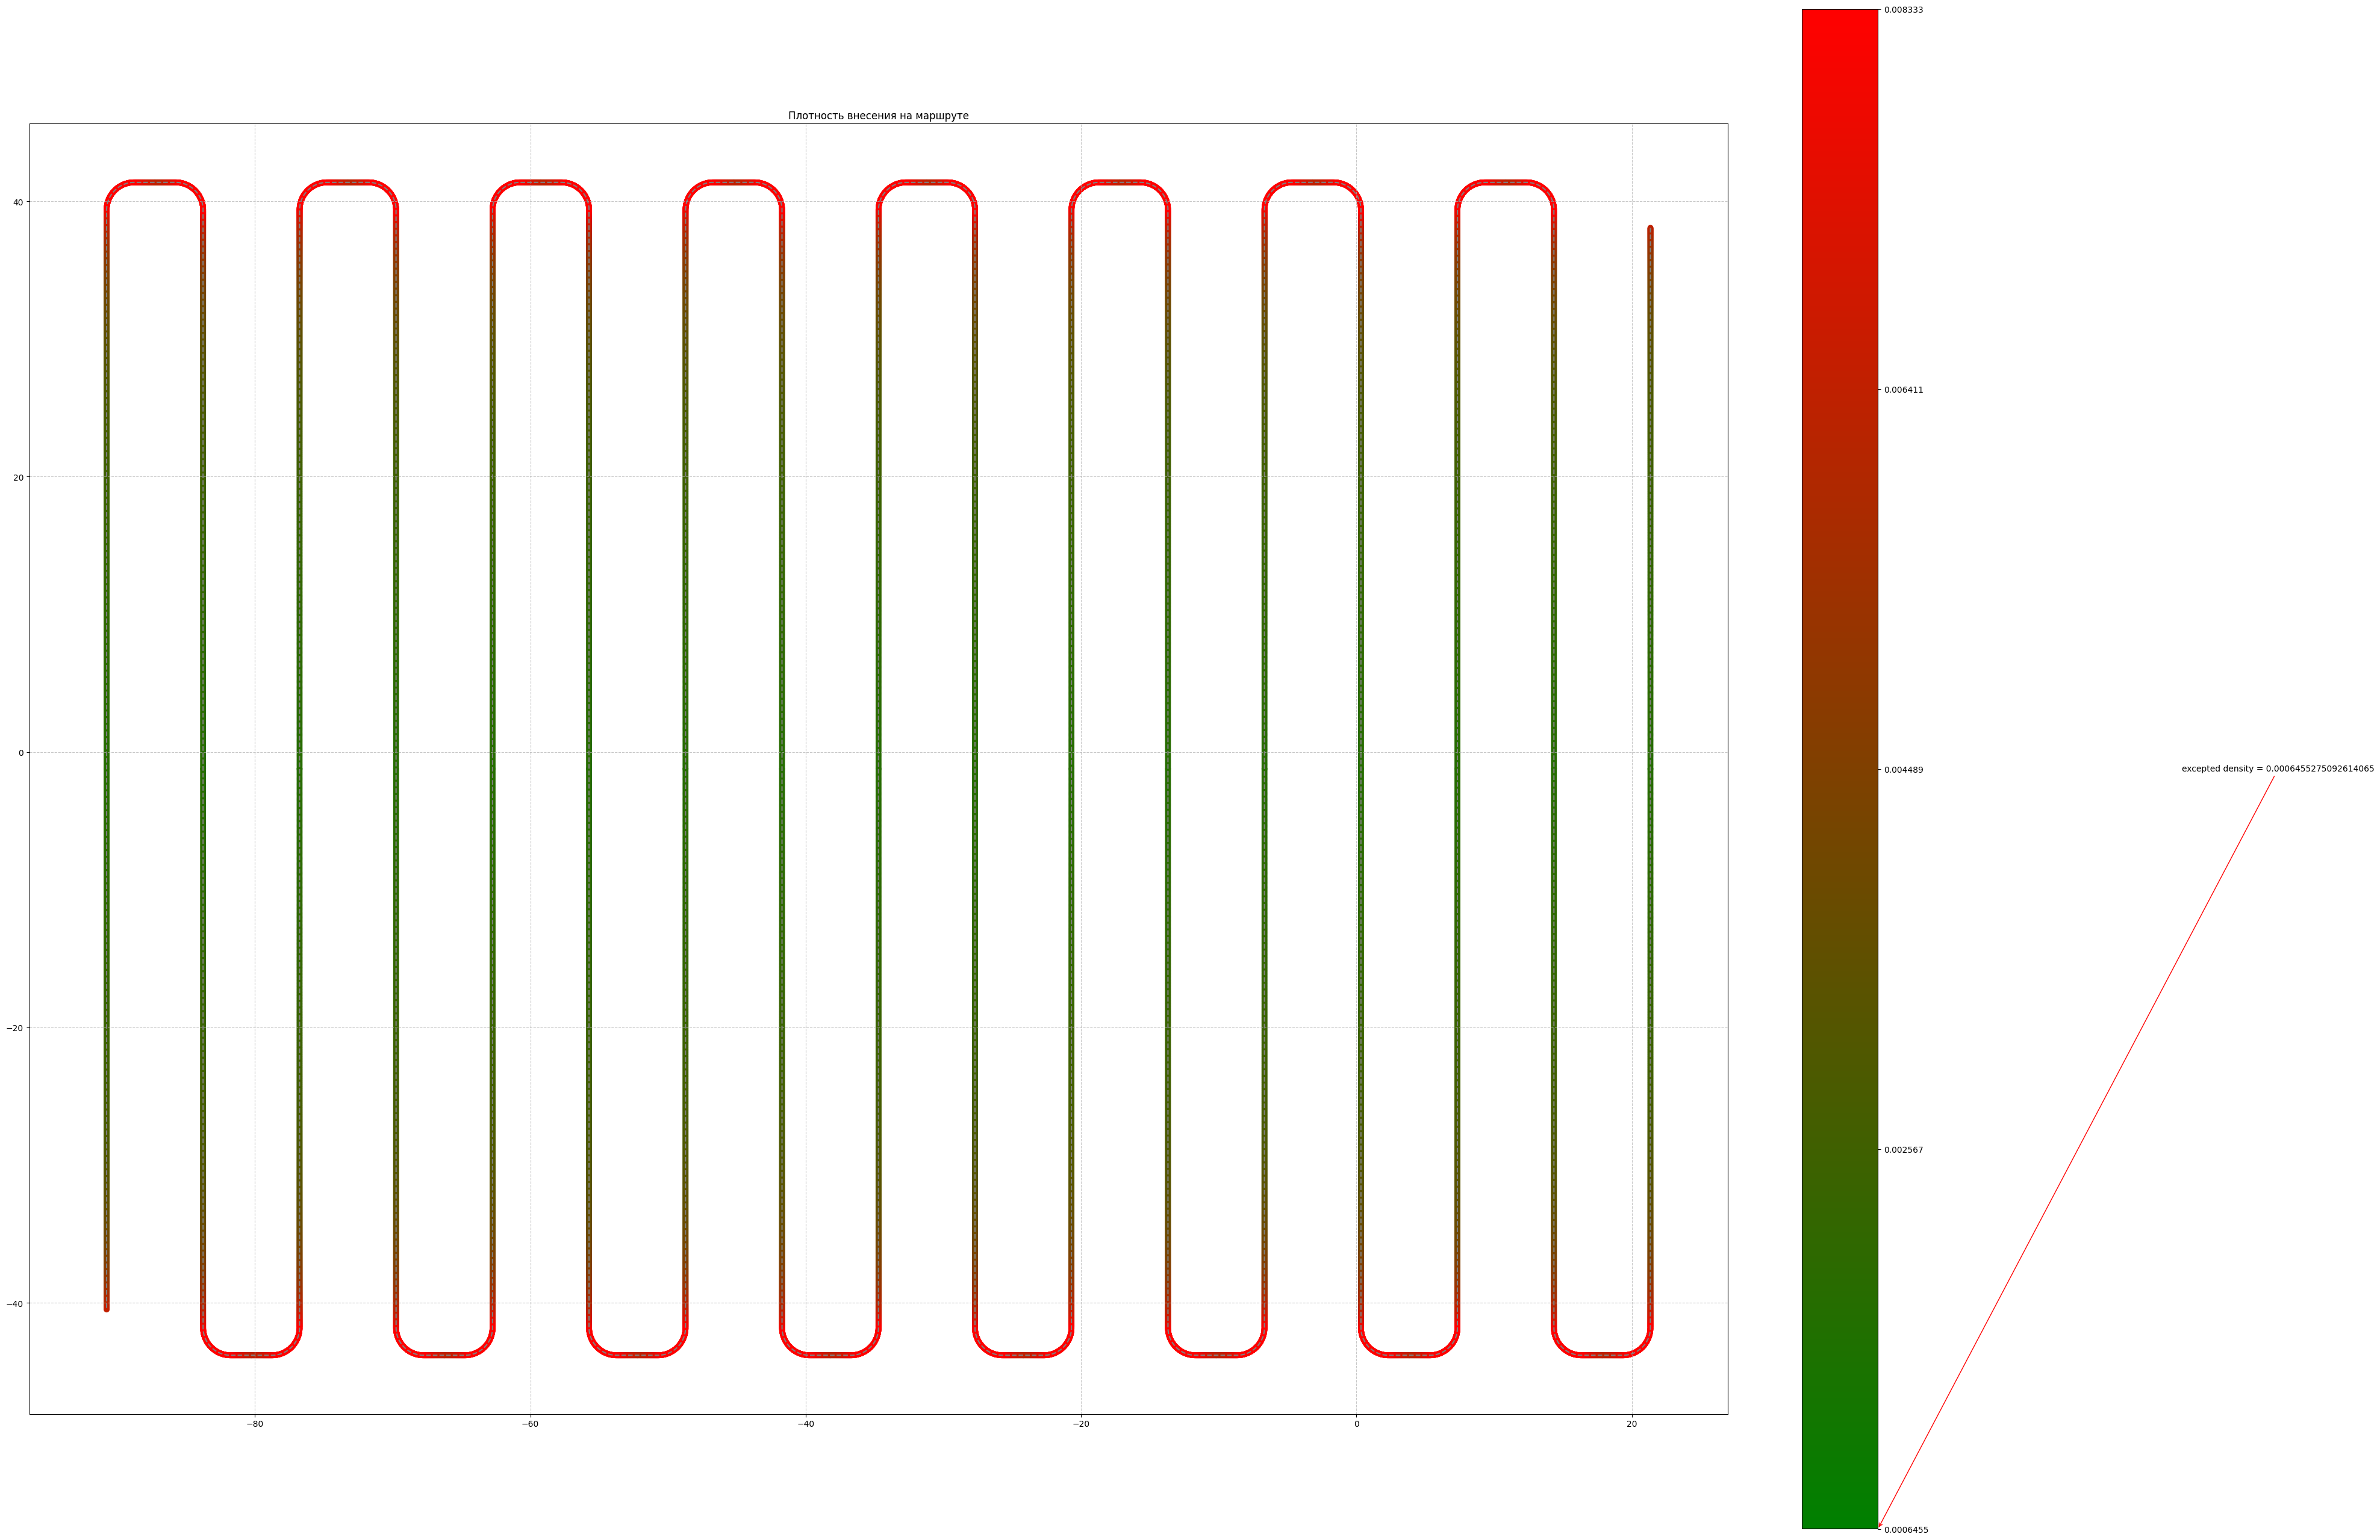

In [69]:
skip = 0.008
plot_density_profile(list_pts,
                     pump_series_by_plan.q,
                     speed_list,
                     V_total / profile_by_plan.total_distance,
                     skip_start=skip, skip_end=skip)

## Отклонения

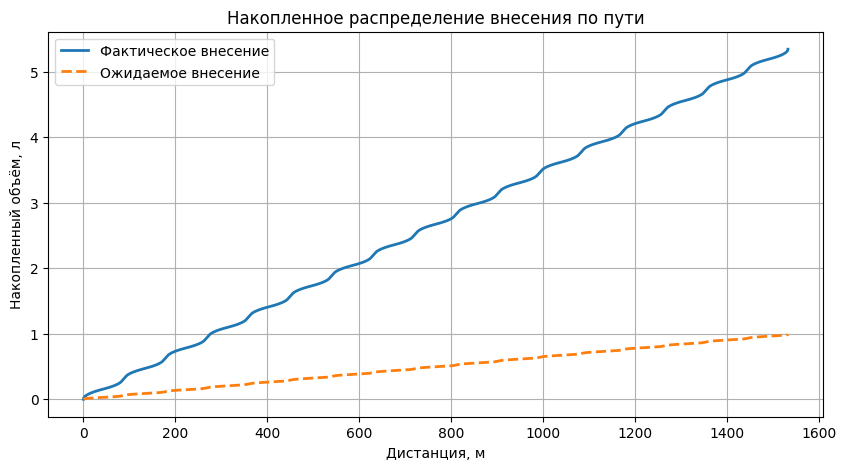

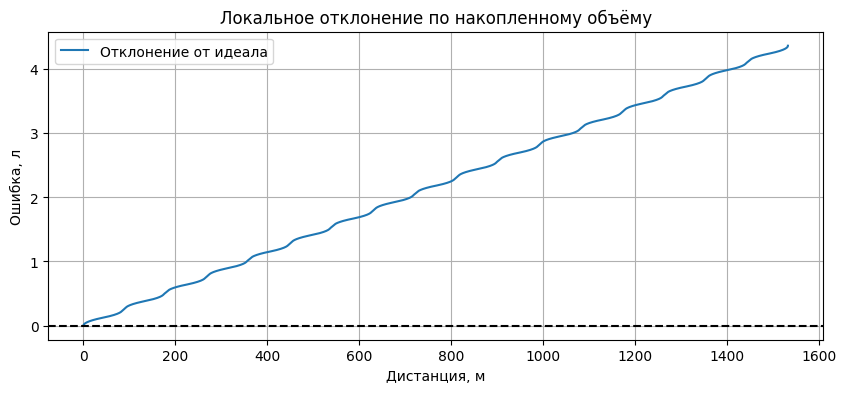

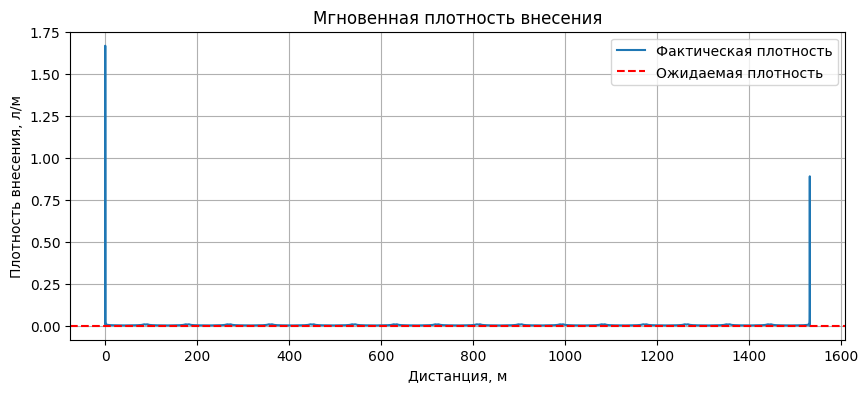

In [70]:
instant_introduction_density_by_logs = PumpController.instantaneous_densities(speed_list, pump_series_by_plan.q)
density = V_total / profile_by_plan.total_distance
plot_diffs(s_list, instant_introduction_density_by_logs, V_total, density)

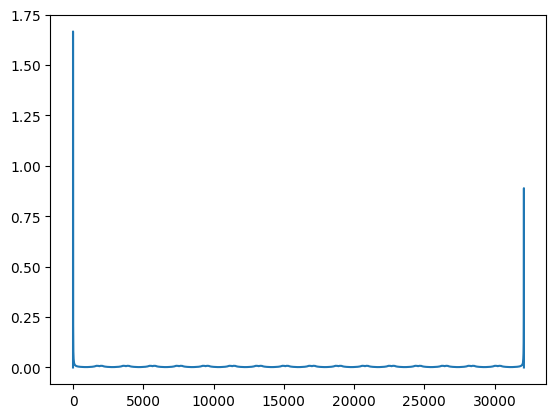

In [71]:
import matplotlib.pyplot as plt

l = PumpController.instantaneous_densities(speed_list, pump_series_by_plan.q)
plt.plot(l)

## Интегрируем, считаем вылитый объём и пройденный маршрут

In [51]:
from scipy import integrate

In [52]:
f = lambda t: pump_series_by_plan.q[np.argmin(pow(np.array(pump_series_by_plan.t) - t, 2))]
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

7.704958771036108 ± 0.010753114628664129


C:\Users\nodax\AppData\Local\Temp\ipykernel_1444\3940417807.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


In [53]:
import numpy as np

print(np.trapezoid(speed_list, pump_series_by_plan.t))

1532.7377390274892


In [54]:
from scipy.integrate import simpson

print(simpson(speed_list, x=pump_series_by_plan.t))

1532.7374767273172


In [55]:
plan.sum_distance_by_waypoints, profile_by_plan.total_distance

(1560.206774122365, 1532.7377390274896)

In [56]:
from scipy import interpolate, integrate

f = interpolate.interp1d(pump_series_by_plan.t, speed_list, kind="linear")  # или "cubic"
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

1534.9958025172684 ± 24.510486474609934


C:\Users\nodax\AppData\Local\Temp\ipykernel_1444\1325149867.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


In [57]:
f = lambda t: speed_list[np.argmin(pow(np.array(pump_series_by_plan.t) - t, 2))]
val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])
print(f"{val} ± {err}")

1537.3937318257958 ± 22.50130043259651


C:\Users\nodax\AppData\Local\Temp\ipykernel_1444\547705918.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = integrate.quad(f, 0.0, pump_series_by_plan.t[-1])


# Берём данные о полёте из логов

## Визуализация всех полётов в лог файле

Полёт № 1


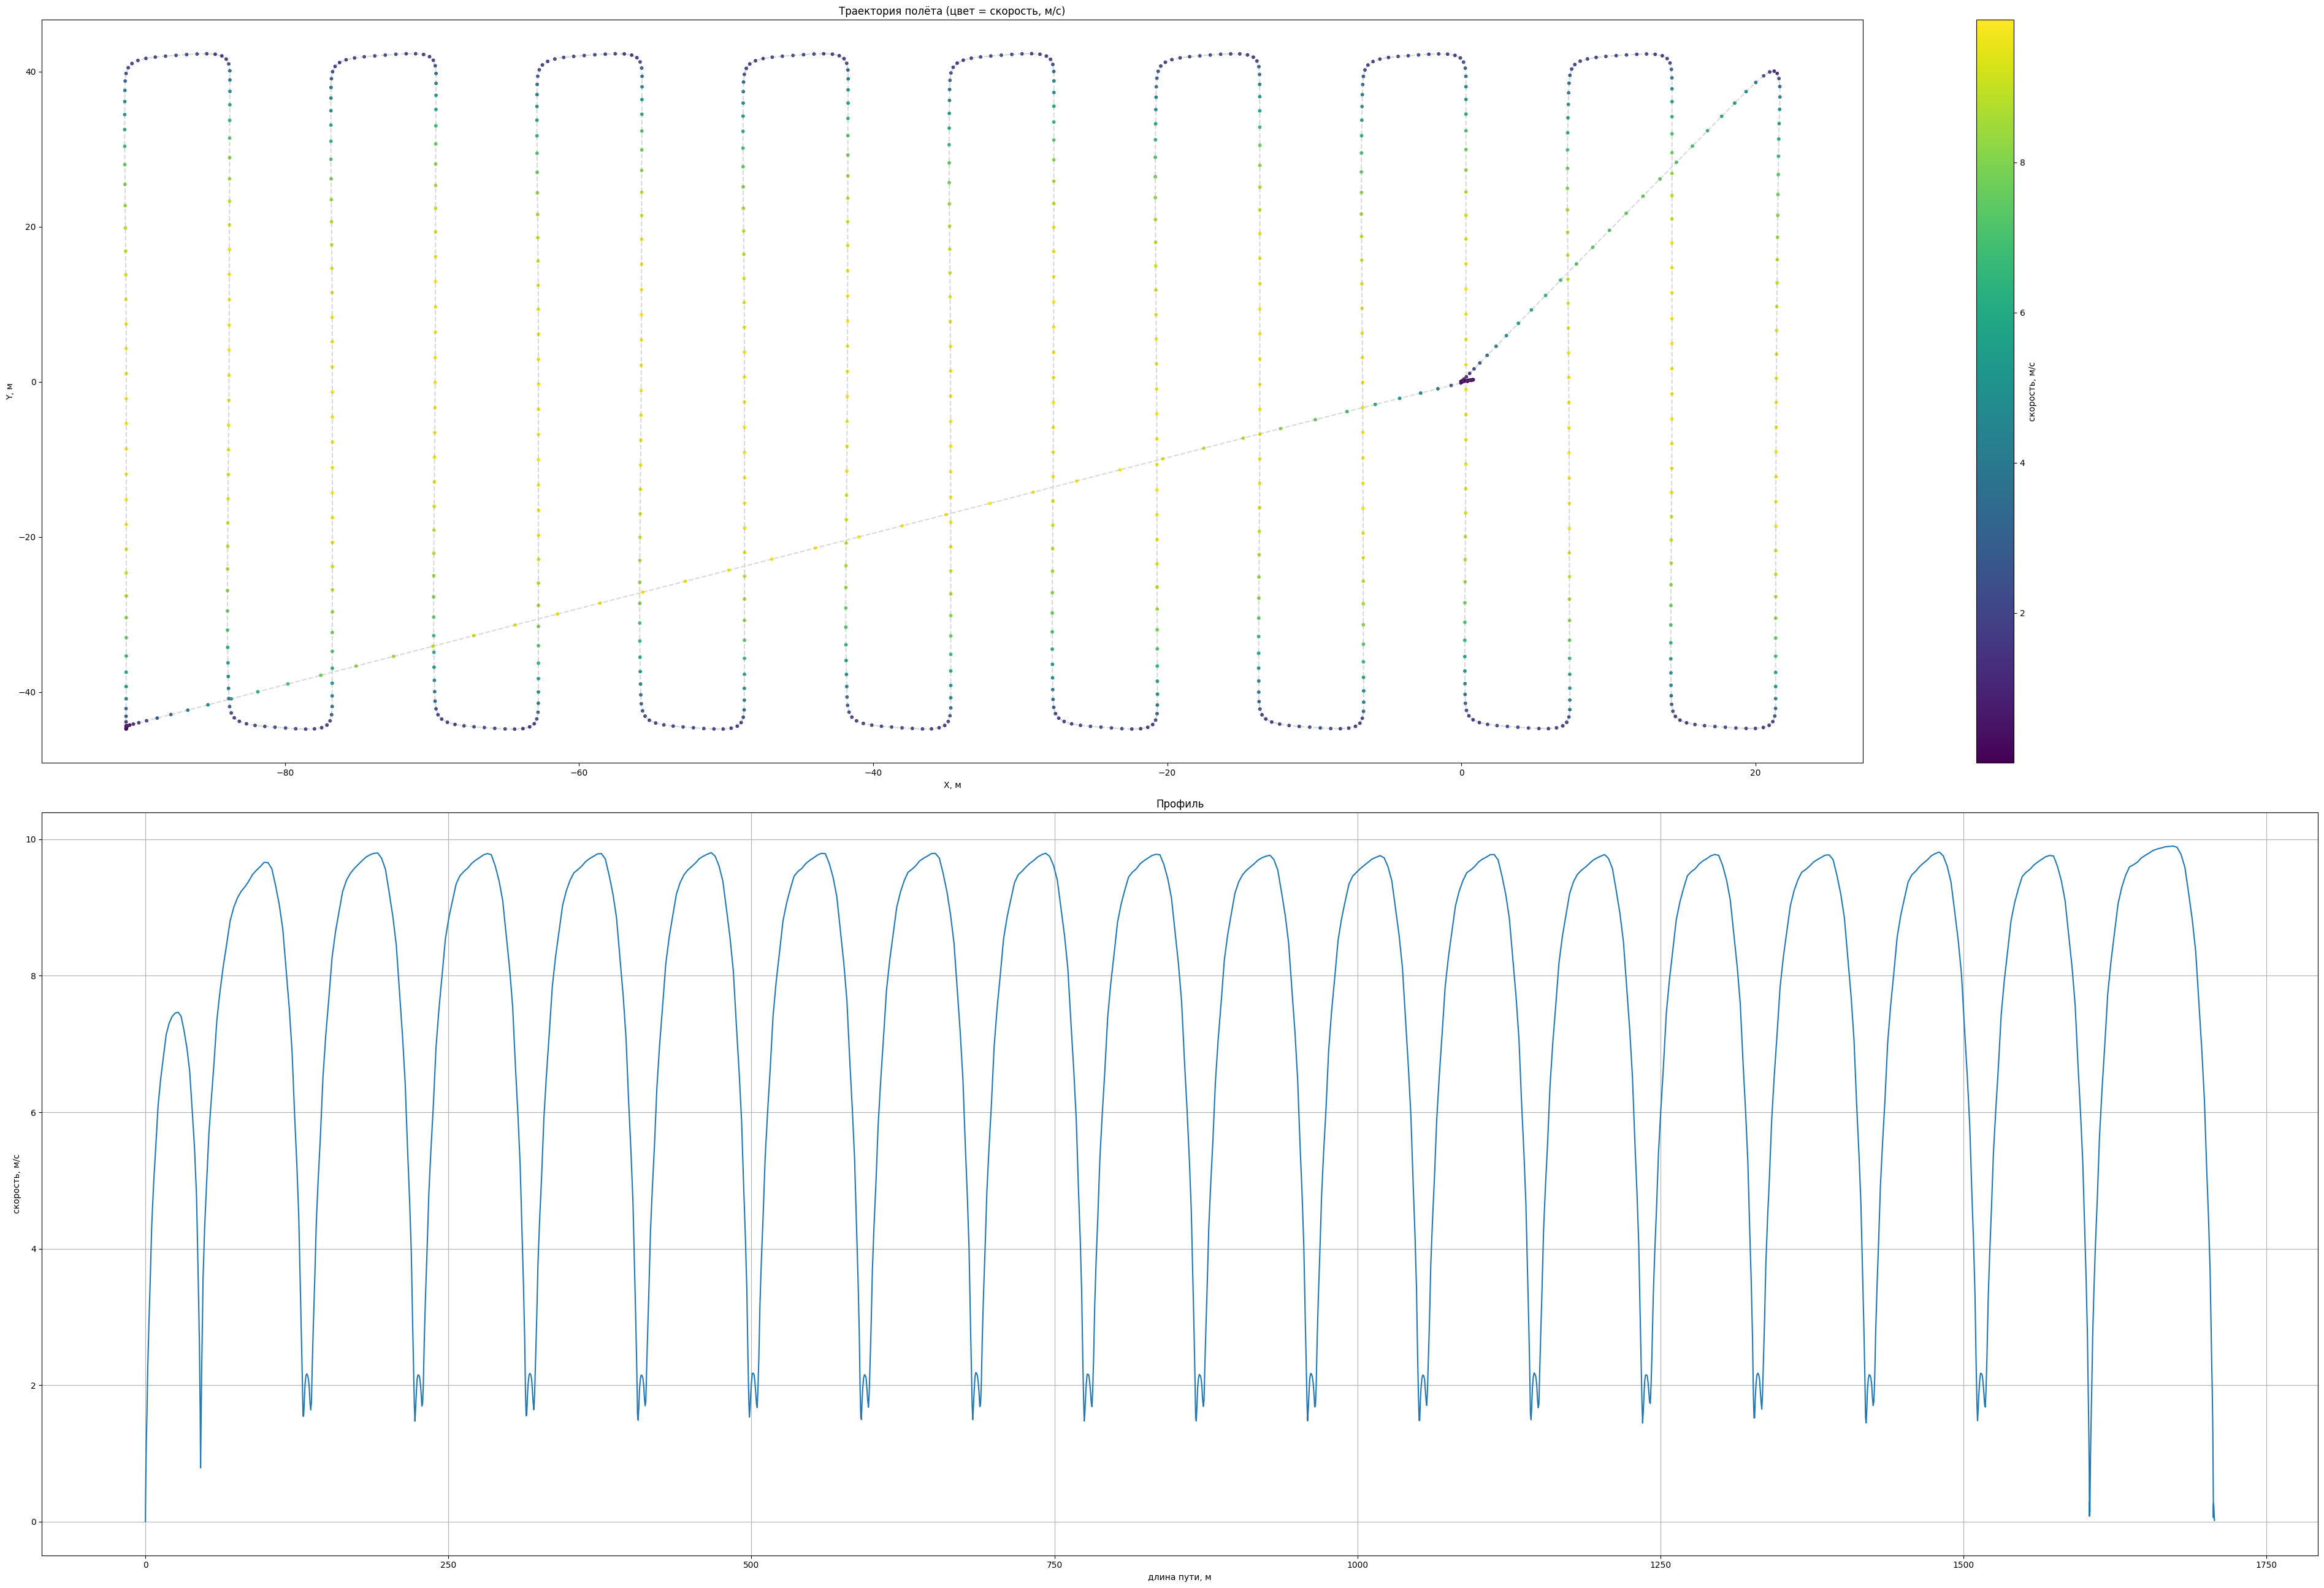

Полёт № 2


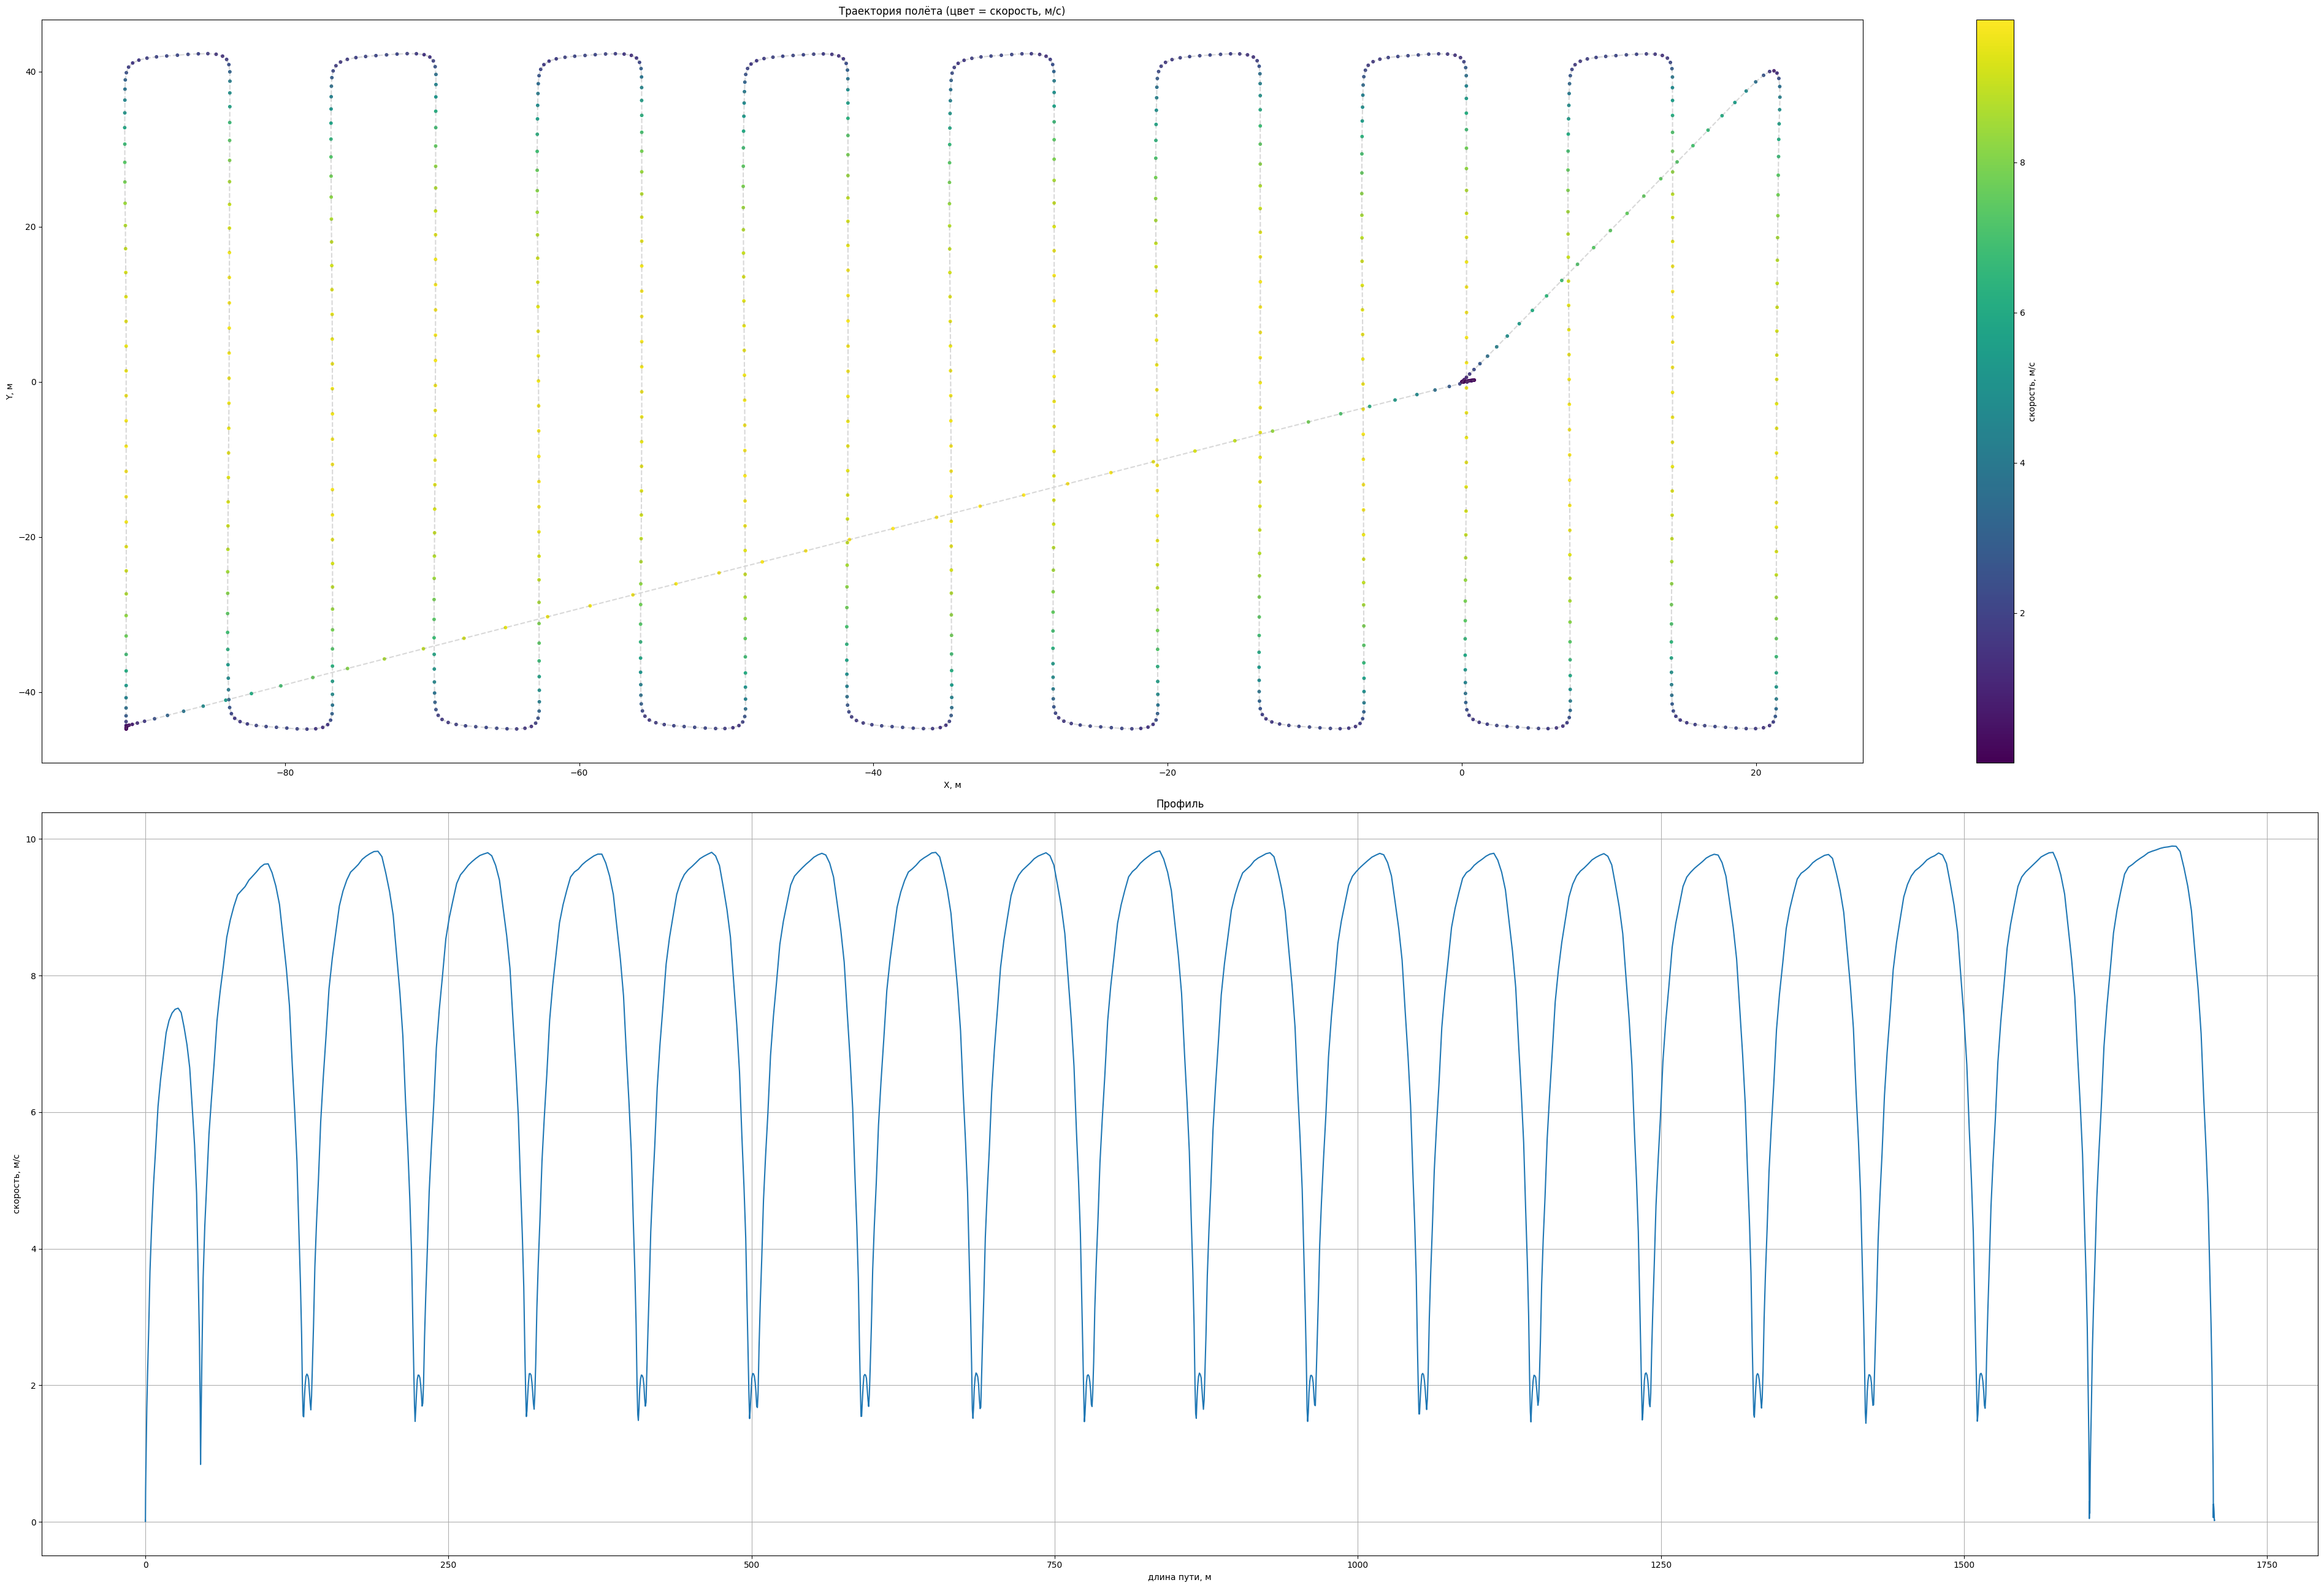

In [58]:
for i, f in enumerate(in_logs.flight_points, 1):
    print(f"Полёт № {i}")
    scatter_with_color_and_profile(f['points'], f['speed'])

## Берём один полёт для анализа

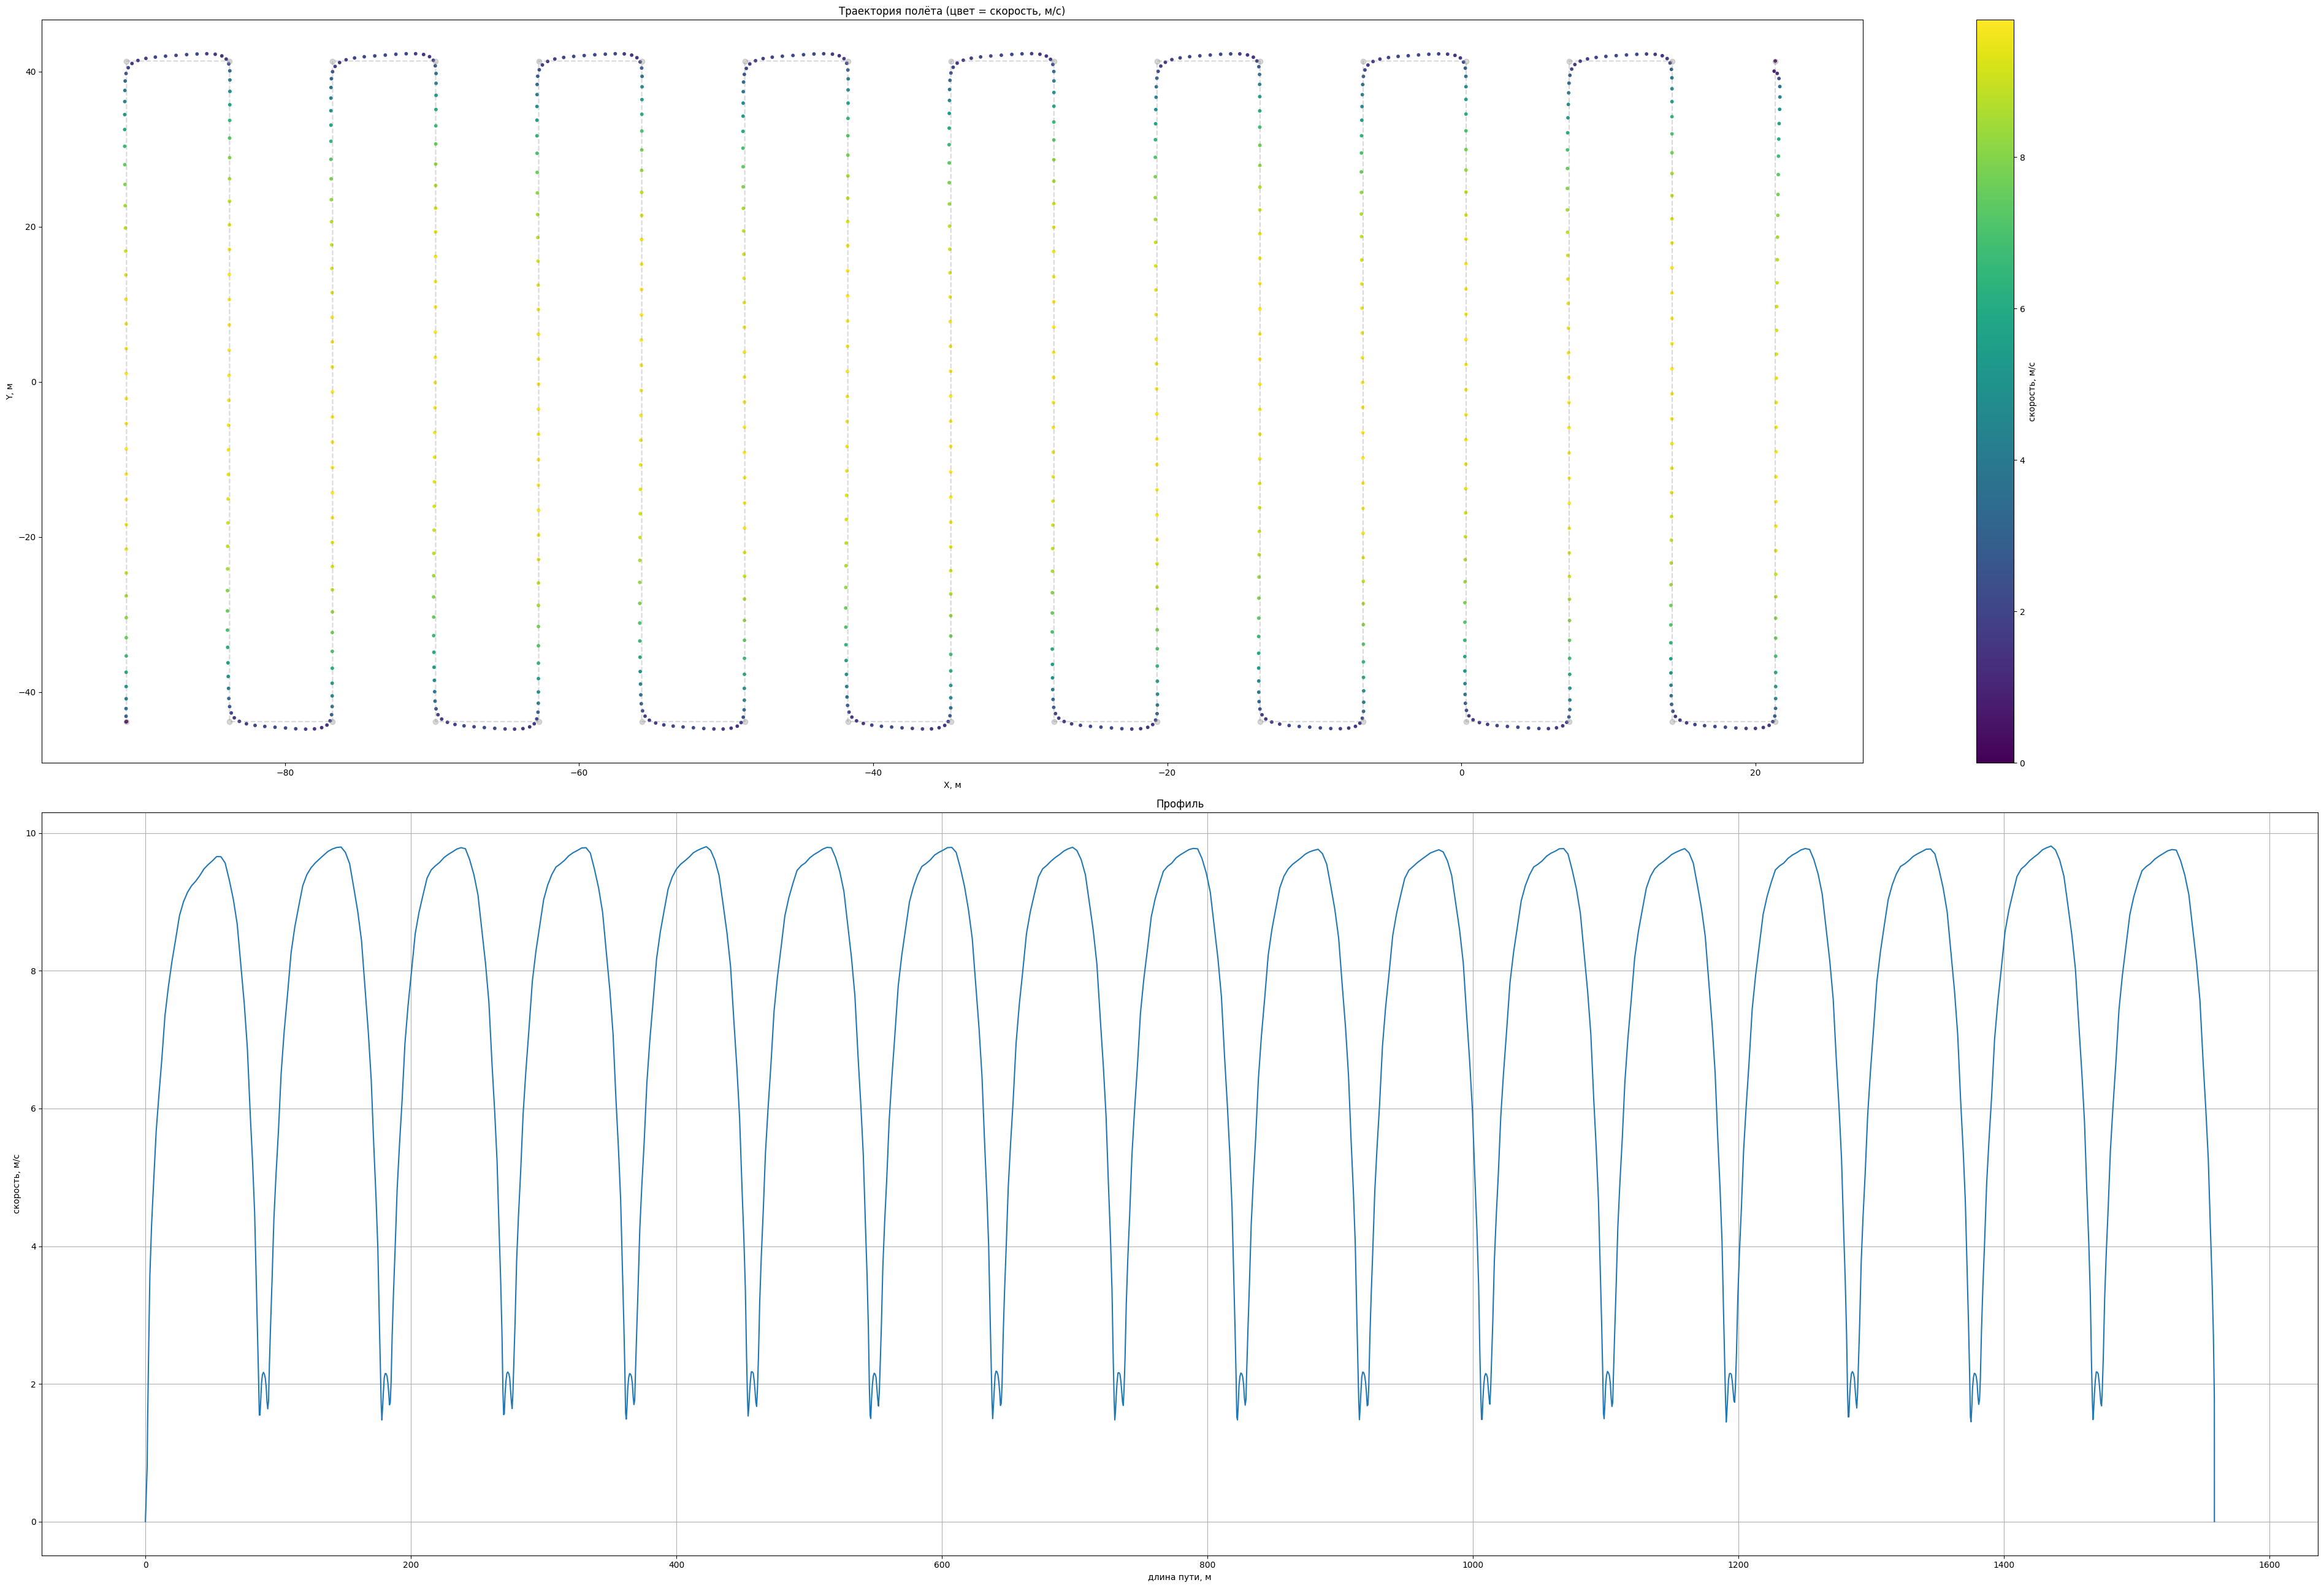

In [59]:
waypoints_by_logs, speed_list_by_logs = in_logs.get_waypoints_and_speed_list(index_fly=0)
scatter_with_color_and_profile(waypoints_by_logs, speed_list_by_logs, waypoints=plan.waypoints_xy)

## Предсказанный на основе логов

In [60]:
t_list = simulate_time_param(waypoints_by_logs, speed_list_by_logs)
profile_by_logs = predictor.build_profile(waypoints_by_logs)

pump_plan_by_logs = pump.compute_flow_series(
    t=t_list,
    v_motion=speed_list_by_logs,
    length=profile_by_logs.total_distance,
    volume_total=V_total,
)

print(f"Длина маршрута L = {profile_by_logs.total_distance :.2f} м")
print(f"Плановый объём V_total = {V_total:.2f} л")
print(f"Фактически выльется (с учётом ограничений насоса): {pump.total_dispensed(pump_plan_by_logs) :.2f} л")
empty_s_list = [profile_by_logs.distance_at_time(t) for t, v in pump_plan_by_logs.empty_events]

if pump_plan_by_logs.empty_events:
    print("Моменты опустошения бака:")
    for (t_empty, V_cum), s in zip(pump_plan_by_logs.empty_events, empty_s_list):
        print(f"\tt = {t_empty:.2f} с, s = {s:.2f} м")
else:
    print("Бак не опустошается в ходе полёта.")


Длина маршрута L = 1558.63 м
Плановый объём V_total = 6.93 л
Фактически выльется (с учётом ограничений насоса): 7.60 л
Моменты опустошения бака:
	t = 172.78 с, s = 368.59 м


## Профиль скорости

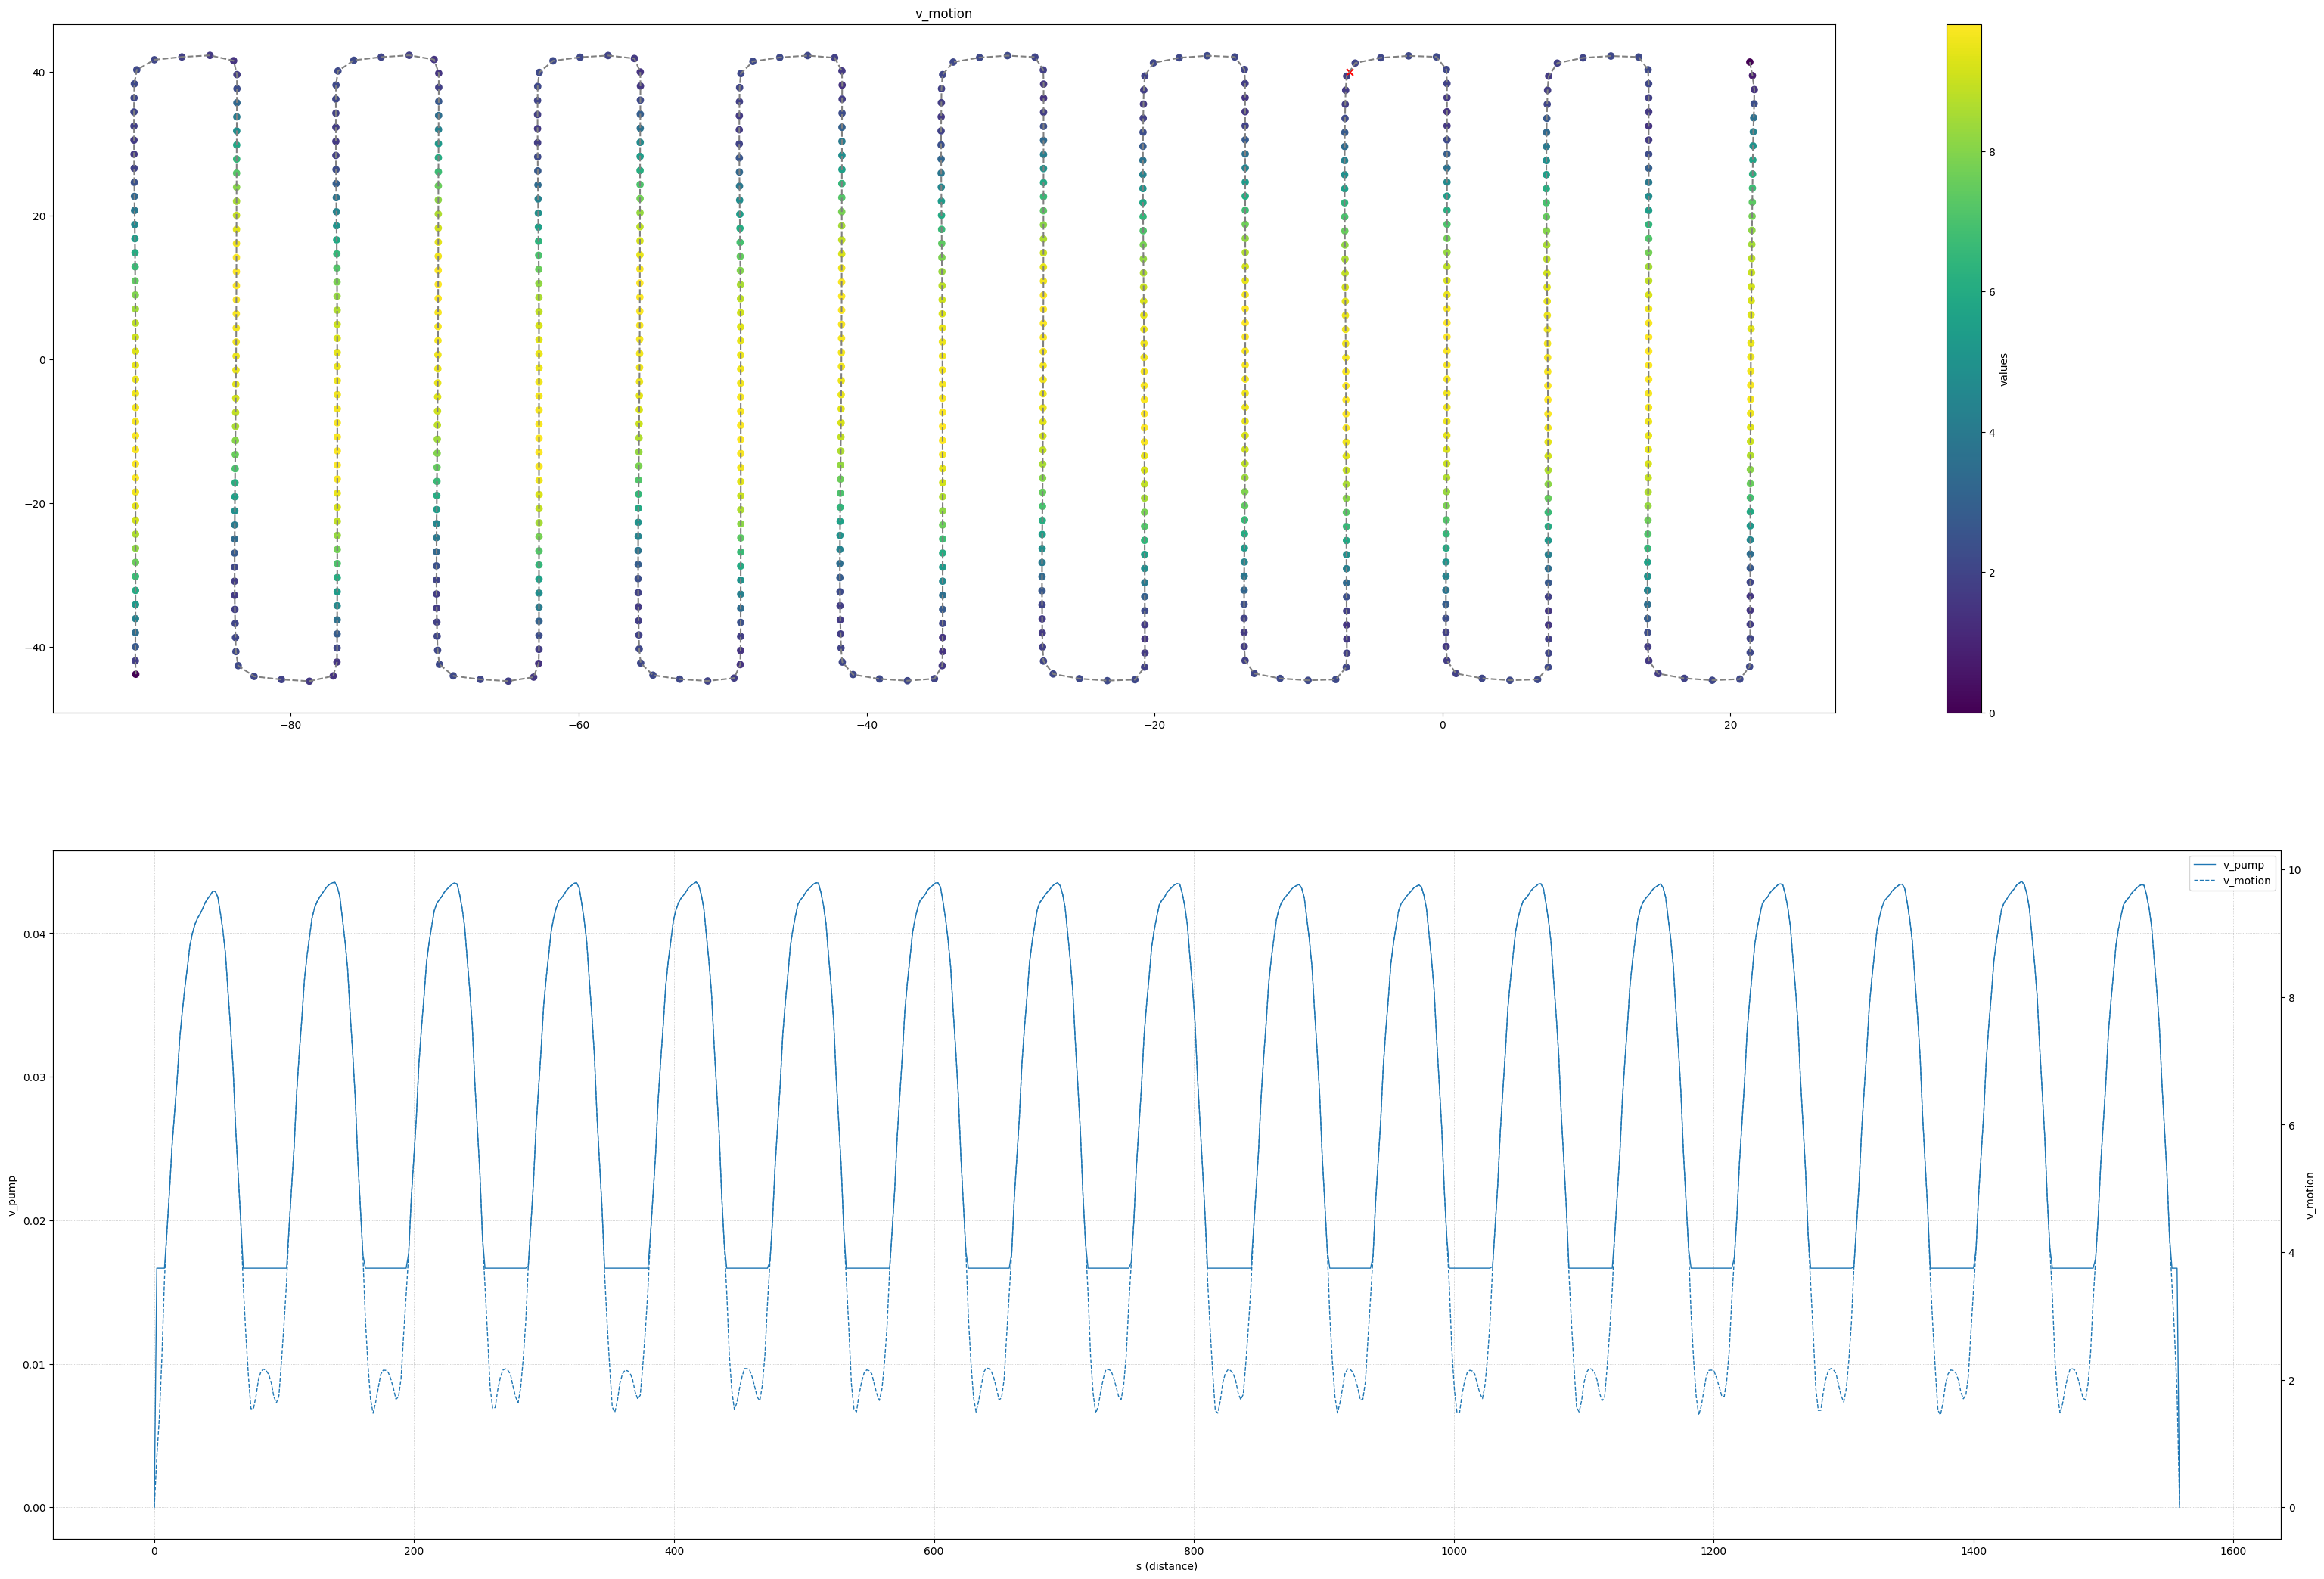

In [61]:
s_list_by_logs = np.linspace(0, profile_by_logs.total_distance, len(waypoints_by_logs))

list_pts = [profile_by_logs.point_at_distance(s) for s in s_list_by_logs]

plot_speeds_profile(list_pts,
                    s_list_by_logs,
                    pump_plan_by_logs.q,
                    speed_list_by_logs,
                    empty_s_list)

## Плотность внесения

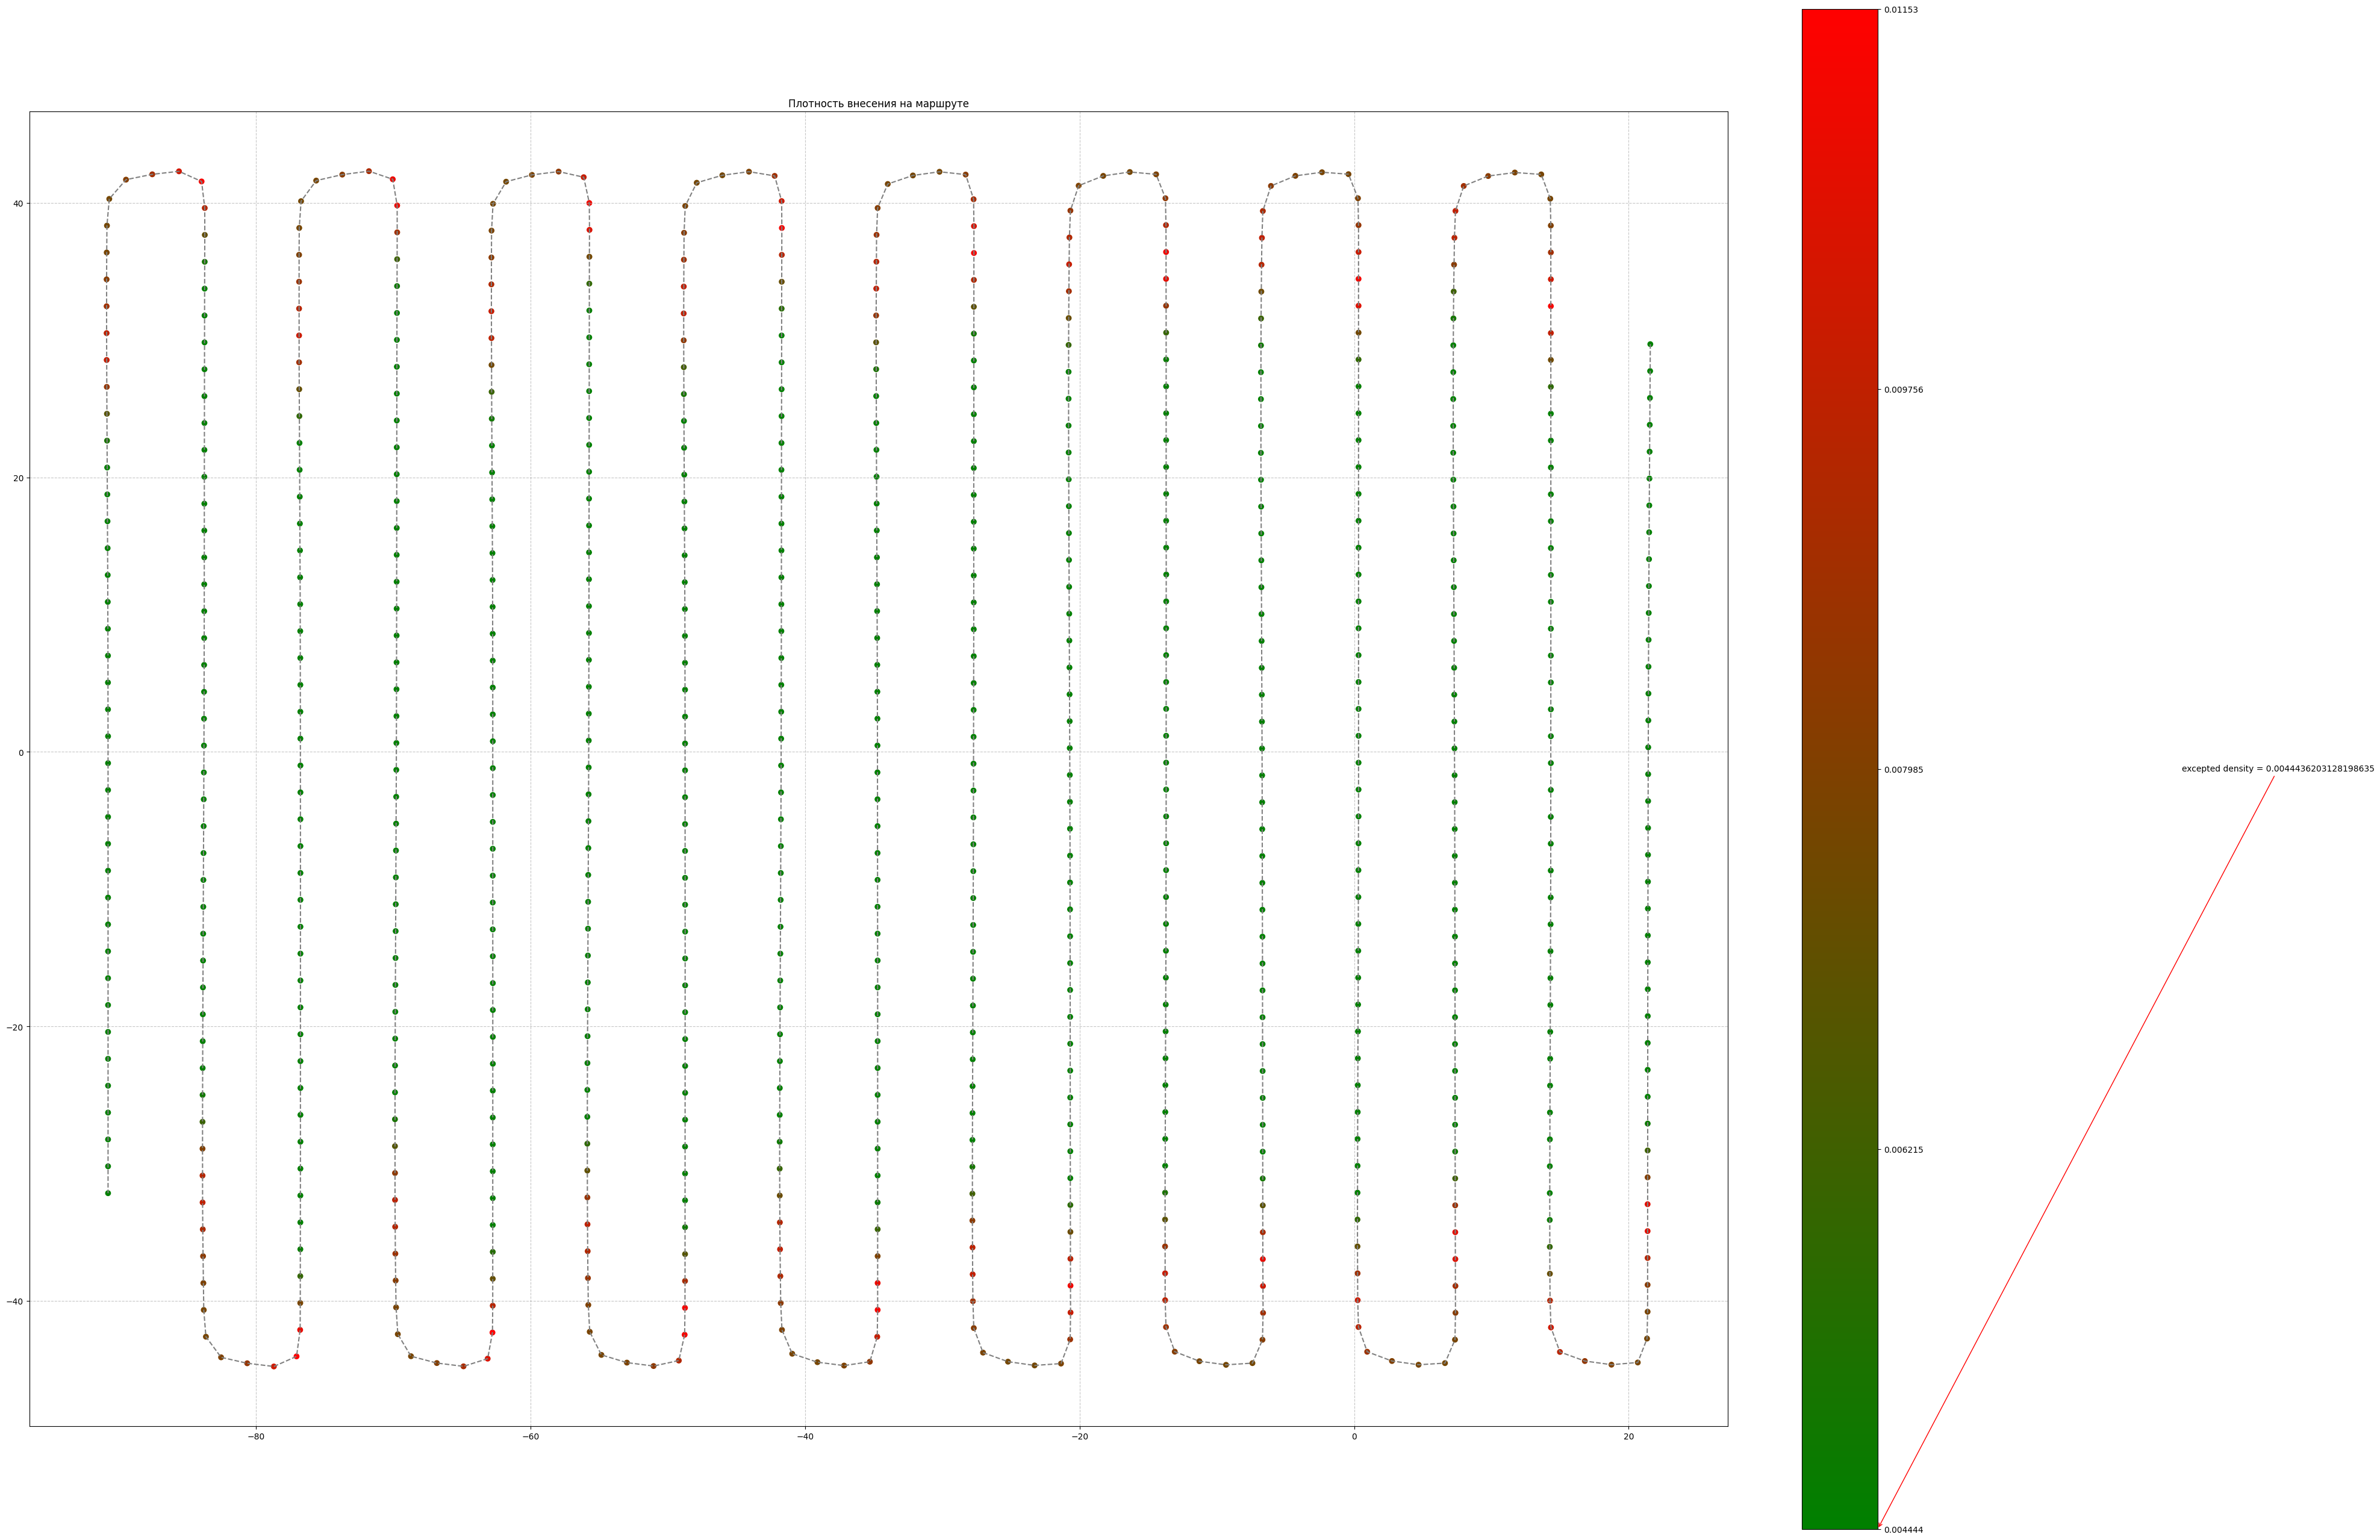

In [62]:
plot_density_profile(list_pts,
                     pump_plan_by_logs.q,
                     speed_list_by_logs,
                     V_total / profile_by_logs.total_distance,
                     skip_start=skip, skip_end=skip)

## Отклонения

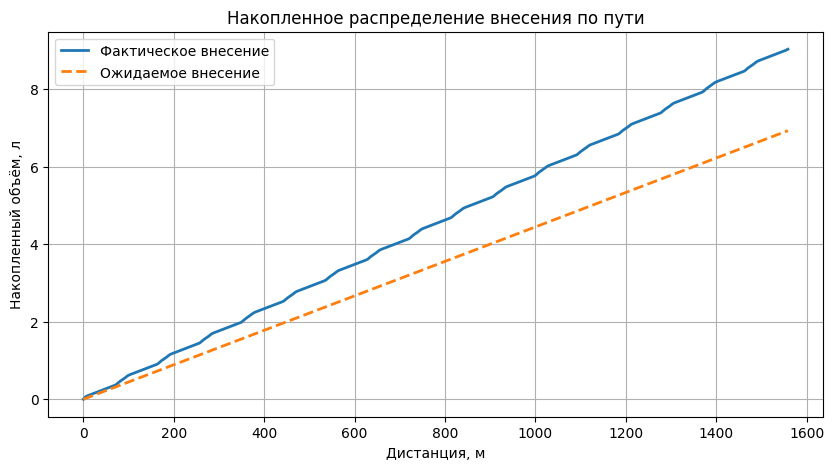

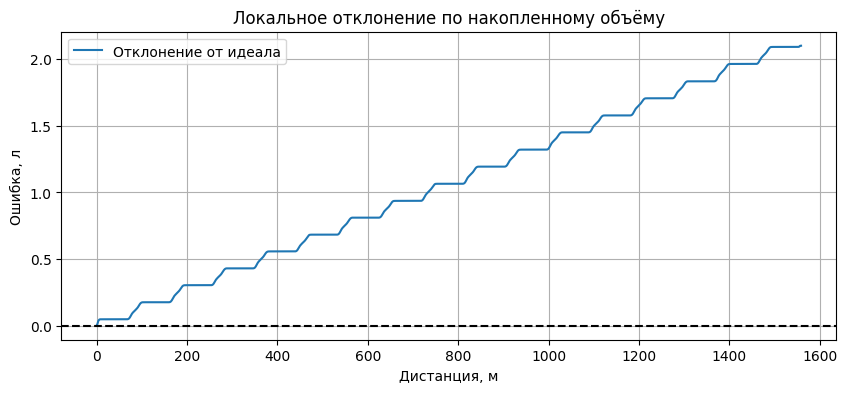

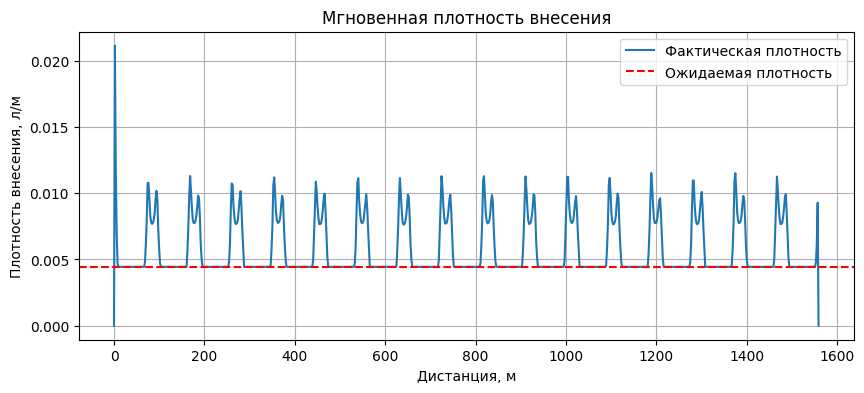

In [63]:
instant_introduction_density_by_logs = PumpController.instantaneous_densities(speed_list_by_logs, pump_plan_by_logs.q)
density = V_total / profile_by_logs.total_distance
plot_diffs(s_list_by_logs, instant_introduction_density_by_logs, V_total, density)